In [2]:
#Import nessesary libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
pd.set_option('display.max_rows',85)
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
from datetime import datetime, timedelta
import glob
import seaborn as sns
import syre
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [3]:
def mals_baseline(y, lam=1e5, p=0.001, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose())
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    
    for i in range(niter):
        W.setdiag(w)
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    
    return z

In [4]:
#IMPORTING CODE FROM ONLINE, SEE REF BELOW. THE ALS IS USED BUT FOR FUTURE REFERENCE SAVING THE ENTIRE DEFINITION OF FUNCTIONS
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 30 16:05:47 2015

@author: M Wieser

LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
"""


import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
# from scikits.sparse.cholmod import cholesky
from scipy import sparse

from scipy.stats import norm
import matplotlib.pyplot as plt


def als(y, lam=1e5, p=0.2, itermax=15):
    """
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)

    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://github.com/vicngtor/BaySpecPlots

    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005

    Description from the original documentation:

    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.


    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            wheighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    L = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z



def arpls(y, lam=1e4, ratio=0.05, itermax=100):
    """
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)

    Abstract

    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.

    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    N = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(N), 2))
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]

    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z

def WhittakerSmooth(x, w, lam, differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        w:
            binary masks (value of the mask is zero if a point belongs to peaks
            and one otherwise)
        lam:
            parameter that can be adjusted by user. The larger lambda is,  the
            smoother the resulting background
        differences:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    X = np.matrix(x)
    m = X.size
#    D = csc_matrix(np.diff(np.eye(m), differences))
    D = sparse.eye(m, format='csc')
    for i in range(differences):
        D = D[1:] - D[:-1]  # numpy.diff() does not work with sparse matrix. This is a workaround.
    W = sparse.diags(w, 0, shape=(m, m))
    A = sparse.csc_matrix(W + (lam * D.T * D))
    B = sparse.csc_matrix(W * X.T)
    background = spsolve(A, B)
    return np.array(background)

def airpls(x, lam=100, porder=1, itermax=100):
    '''
    airpls.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
    Baseline correction using adaptive iteratively reweighted penalized least squares

    This program is a translation in python of the R source code of airPLS version 2.0
    by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
    Reference:
    Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive
    iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

    Description from the original documentation:

    Baseline drift always blurs or even swamps signals and deteriorates analytical
    results, particularly in multivariate analysis.  It is necessary to correct
    baseline drift to perform further data analysis. Simple or modified polynomial
    fitting has been found to be effective in some extent. However, this method
    requires user intervention and prone to variability especially in low
    signal-to-noise ratio environments. The proposed adaptive iteratively
    reweighted Penalized Least Squares (airPLS) algorithm doesn't require any
    user intervention and prior information, such as detected peaks. It
    iteratively changes weights of sum squares errors (SSE) between the fitted
    baseline and original signals, and the weights of SSE are obtained adaptively
    using between previously fitted baseline and original signals. This baseline
    estimator is general, fast and flexible in fitting baseline.

    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        porder:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    m = x.shape[0]
    w = np.ones(m)
    for i in range(1, itermax + 1):
        z = WhittakerSmooth(x, w, lam, porder)
        d = x - z
        dssn = np.abs(d[d < 0].sum())
        if(dssn < 0.001 * (abs(x)).sum() or i == itermax):
            if(i == itermax):
                print('airpls: max iteration reached!')
            break
        w[d >= 0] = 0  # d>0 means that this point is part of a peak,
        # so its weight is set to 0 in order to ignore it
        w[d < 0] = np.exp(i * np.abs(d[d < 0]) / dssn)
        w[0] = np.exp(i * (d[d < 0]).max() / dssn)
        w[-1] = w[0]
    return z


In [5]:
#Here we define the mathematical functions for the fittings of XRD peaks

def gaussian(x, c, a, s): 
    return a * np.exp(-(x-c)**2 / (2*s**2))

def lorentzian(x, c, a, g): 
    return a*((g**2)/ ((x-c)**2 + g**2))

def pseudo_voigt(x, c, a, s, g, eta):
    #eta is the mixing parameter, 0 if pure gaussian, 1 if pure lorentzian. Eta has to be between 0 and 1
    return  (1-eta)*gaussian(x, c, a, s) + eta*lorentzian(x, c, a, g)

In [6]:
from scipy.optimize import least_squares

def residuals(params, x,y):
    return y - gaussian(x, *params)

def fit_least_squares(x,y,initial_guess, lower_bounds, upper_bounds, plot):
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, label='Original Data', color='blue', alpha=0.7)
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
    param = least_squares(residuals, initial_guess, bounds = (lower_bounds,upper_bounds), args=(x,y))
    c,a,s = param.x
    yf = gaussian(x,c,a,s)
    amplitude = max(yf)
    fwhm = s*2*np.sqrt(2*np.log(2))
    resi = y - yf
    if plot: 
        plt.plot(x, yf, label='Gaussian Fit', color='red')
        plt.scatter(x, resi, label='residuals', color='green', alpha=0.7)
        plt.scatter([], [], label=' stdv:' + str(s)+ ' fwhm:'+ str(wsum), color='red', alpha=0.7)
        plt.title('Gaussian fitting and residuals')
        plt.legend()
        plt.show()
    return c,amplitude, s, fwhm,resi

In [7]:
#This code if to read xrdml files into a dataframe
def read_PL_em(file):
    # Read parameters section
    line_counter = 0
    with open(file, 'r', encoding='ISO-8859-1') as f:
        params = {}
        for line in f:
            line_counter += 1
            if line.startswith('  Sample :'):
                params['sample'] = line.split(':')[1].strip()
            elif line.startswith('  Start_Date :'):
                params['date'] = line.split(':')[1].strip()
            elif line.startswith('  Start_Time :'):
                params['time'] = ':'.join(line.split(':')[1:]).strip()
            elif line.startswith('Data:'):
                params['data_start'] = line_counter
                break
        f.close()
    #Read wavelength and intensity data
    data = pd.read_csv(file, sep='\t', skiprows=lambda x: x <= params['data_start'], 
                      names=['wavelength', 'intensity'], encoding='ISO-8859-1')
    wavelength = data['wavelength'].values
    intensity = data['intensity'].values

    return {
        'timestamp': params['date']+ ' '+ params['time'],
        'wavelength': wavelength,
        'intensity': intensity
    }
    

In [8]:
def read_TRPL(file):   
    line_counter = 0
    with open(file, 'r', encoding='ISO-8859-1') as f:
        params = {}
        for line in f:
            line_counter += 1
            if line.startswith('  Sample :'):
                params['sample'] = line.split(':')[1].strip()
            elif line.startswith('  Start_Date :'):
                params['date'] = line.split(':')[1].strip()
            elif line.startswith('  Start_Time :'):
                params['time'] = ':'.join(line.split(':')[1:]).strip()
            elif line.startswith('  Det_Wavelength :'):
                params['detection_lam'] = line.split(':')[1].strip()
                print(params['detection_lam'])
            elif line.startswith('Data:'):
                params['data_start'] = line_counter
                break
        f.close()
    #Read wavelength and intensity data
    data = pd.read_csv(file, sep='\t', skiprows=lambda x: x <= params['data_start'], 
                      names=['Time', 'Intensity'], encoding='ISO-8859-1')
    time_ns = data['Time'].values
    intensity = data['Intensity'].values
    return {
        'timestamp': params['date']+ ' '+ params['time'],
        'TRPL_lambda': params['detection_lam'],
        'TRPL_ns': time_ns,
        'TRPL_intensity': intensity
    }

In [9]:
#This function fits a peak that had been selected, using the Pseudo-Voigt

def fit_to_peak(x, y, plot, s = 0.05): #Fit a Pseudo-Voigt curve to the data and return the parameters.
    center_guess = x[np.argmax(y)]  # Initial guess for the center of the peak is the x-value with maximum y
    initial_guess = [center_guess, max(y), s]  # Initial guess for amplitude, center, stddevG (sigma), fwhmL(gamma), eta
    lower_bounds = [0, 0, 0.001]  # eta >= 0
    upper_bounds = [np.inf, np.inf, 1]  # eta <= 1
    try:
        c,amp,stdv, fwhm, resi = fit_least_squares(x, y, initial_guess, lower_bounds, upper_bounds, plot)
    except (RuntimeError, ValueError, TypeError) as e:
        print(f'Gaussian fit failed: {e}')
    return c, amp, stdv, fwhm, resi # Return center, amplitude, stddvG, fwhm, residuals

In [10]:
import math

def plancks(lam, h_planks = 6.62607015e-34, c_light = 299792458, e_charge = 1.602176634e-19):	
    E = h_planks*c_light/lam
    return E                                      

def plancks_reverse(E, h_planks = 6.62607015e-34, c_light = 299792458, e_charge = 1.602176634e-19):
    lam = h_planks*c_light/E
    return lam


In [11]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

#Defining functions nessesary for the Nelson Riley regression plot and fitting

import math

def linear(x,a,c):
    return (a*x+c)

def lin_residuals(param, x, y):
    return y - linear(x, *param)

def TRPL_fit(x, param, nr_parameters, IF = False): #param is a tuple containing the fitting parameters
    #Fits a TRPL (Time-Resolved Photoluminescence) model to the provided data.
    '''    Args:
        x (numpy.ndarray): The independent variable (e.g. time).
        y (numpy.ndarray): The dependent variable (e.g. photoluminescence intensity).
        nr_parameters (int): The number of parameters to use in the TRPL model (1-4).
        param (tuple): A tuple containing the fitting parameters:
                - For nr_parameters=1: (a, c) for linear fit
                - For nr_parameters=2: (a, b, c) for quadratic fit
                - For nr_parameters=3: (a, b, c, d) for cubic fit
                - For nr_parameters=4: (a, b, c, d, e) for quartic fit
        IF (bool, optional): Whether to apply an Iterative Fitting algorithm. Defaults to False.    
    Returns:
        The result of the TRPL model fitting.'''
    if nr_parameters == 1:
        a, c = param
        return linear(x, a, c)
    elif nr_parameters == 2:
        a, b, c = param
        return a*x**2 + b*x + c
    elif nr_parameters == 3:
        a, b, c, d = param
        return a*x**3 + b*x**2 + c*x + d
    elif nr_parameters == 4:
        a, b, c, d, e = param
        return a*x**4 + b*x**3 + c*x**2 + d*x + e
    else:
        raise ValueError("Number of parameters must be between 1 and 4")    
    return 

def TRPL_residuals(param, x, y):
    return y - TRPL_fit(x, param)

def mono_exponential(t, A, tau):
    return A * np.exp(-t/tau)
def bi_exponential(t, A1, tau1, A2, tau2):
    return A1 * np.exp(-t/tau1) + A2 * np.exp(-t/tau2)
def tri_exponential(t, A1, tau1, A2, tau2, A3, tau3):
    return A1 * np.exp(-t/tau1) + A2 * np.exp(-t/tau2) + A3 * np.exp(-t/tau3)


In [12]:
def fit_trpl(time, intensity, model='biexponential', Fitplot=False, timeout=30):
    
    sort_idx = np.argsort(time)
    time = time[sort_idx]
    intensity = intensity[sort_idx]
    
    baseline = intensity[0:103].mean()
    intensity = intensity - baseline

    start_idx = np.argmax(intensity)
    time = time[start_idx:]
    intensity = intensity[start_idx:]


    max_time1 = 5
    mask1 = time < max_time1
    time1 = time[mask1]
    intensity1 = intensity[mask1]
    max_time2 = 90
    mask2 = (max_time1 <= time) & (time <= max_time2)
    time2 = time[mask2]
    intensity2 = intensity[mask2]


    if Fitplot:
        fig2 = plt.figure(figsize=(8, 6))
        ax2 = fig2.gca()
        #plt.plot(time, intensity, 'o', color = 'k', label='Data', alpha=0.5)
        ax2.set_xlabel('Time (ns)')
        ax2.set_ylabel('Intensity (counts)')
        ax2.plot(time1, intensity1, 'o', label='Data', alpha=0.5)
        fig3 = plt.figure(figsize=(8, 6))
        ax3 = fig3.gca()
        #plt.plot(time, intensity, 'o', color = 'k', label='Data', alpha=0.5)
        ax3.set_xlabel('Time (ns)')
        ax3.set_yscale('log')
        ax3.set_ylabel('Intensity (counts)')
        ax3.plot(time2, intensity2, 'o', label='Data', alpha=0.5)

    if len(time) != len(intensity):
        raise ValueError("Time and intensity arrays must have the same length")

    if not all(np.isfinite(intensity)):
        raise ValueError("Intensity array contains non-finite or nan values")

    # Initial parameter guesses
    if model == 'monoexponential':
        p0 = [np.max(intensity), np.mean(time)]
        fit_func = mono_exponential
    elif model == 'biexponential':
        p0 = [np.max(intensity)/2, np.mean(time), np.max(intensity)/2, np.mean(time)*2]
        fit_func = bi_exponential
    elif model == 'triexponential':
        max_int = np.max(intensity2)
        mid_int = np.median(intensity2)
        min_int = np.min(intensity2)
        p0 = [
            np.abs(max_int*0.7), 20,      # Fast component
            np.abs(mid_int*0.2), 100,     # Medium component 
            np.abs(min_int*0.1), 500     # Slow component
        ]
        print(p0)
        #p0 = [np.max(intensity)/3, np.mean(time), np.max(intensity)/3, np.mean(time)*2, np.max(intensity)/3, np.mean(time)*3]
        fit_func = tri_exponential
    else:
        raise ValueError("Invalid model specified")

    bounds_low = [0, 1, 0, 10, 0, 50]  # Avoid negative or zero amplitudes/lifetimes
    bounds_high = [max_int*5, 200, max_int*3, 2000, max_int*2, 20000]  # Upper bounds for amplitudes/lifetimes
    # Perform the fit
    try:
        popt, pcov = curve_fit(fit_func, time2, intensity2, p0=p0, bounds=(bounds_low, bounds_high), max_nfev=1000)
    except TimeoutError:
        print("Fitting took too long. Skipping this sample.")
        return None, None, None
    except RuntimeError:
        print("Fitting failed. Skipping this sample.")
        return None, None, None
    if Fitplot:
        ax3.plot(time2, fit_func(time2, *popt), 'r-', label='Fit')
        ax3.legend()
        ax3.set_title(f'TRPL Decay Fit\nτ1={1/popt[1]:.2f}ns, τ2={1/popt[3]:.2f}ns')
        ax2.grid(True)

    # Calculate fit quality metrics
    y_fit = fit_func(time2, *popt)
    mse = mean_squared_error(intensity2, y_fit)
    r2 = r2_score(intensity2, y_fit)

    # Get linear region indices
    linear_region = np.where((time1 > 3) & (intensity1 > 500))[0]  # adjust time window as needed    # Fit linear part with max tries
    try:
        slope, intercept = np.polyfit(time1[linear_region], intensity1[linear_region], 1, rcond=1e-3, full=False)
        ax2.plot(time1, intercept + slope*time1, 'r-', label=f'Linear Fit\nSlope={slope:.2f}')
    except: 
        print("Linear fit of initial part failed")
    return popt, y_fit, {'mse': mse, 'r2': r2}, slope, intercept

In [13]:
#fit_to_peak(x,y, True)

In [14]:
from scipy.signal import find_peaks, peak_prominences
import numpy as np

def detect_shoulders(x_data, y_data, prominence_threshold=0.1, width_threshold=5):
    peaks, properties = find_peaks(y_data, prominence=prominence_threshold, width=width_threshold)
    prominences = peak_prominences(y_data, peaks)[0]
    
    # Separate main peaks from shoulders based on relative prominence
    main_peaks = peaks[prominences > np.max(prominences) * 0.5]
    shoulders = peaks[prominences <= np.max(prominences) * 0.5]
    
    return main_peaks, shoulders, prominences

In [15]:
#This function background-corrects and fits the entire x,y array input with certain thresholds

def fit_PLem(ax, lambda_array, intensity_array, file, Fitplot, col, alp, l):   #min_xdelta=0.5, y_thres=100
    # Example usage
    main_peaks, shoulders, prominences = detect_shoulders(lambda_array, intensity_array)
    if Fitplot == True:
        ax.plot(lambda_array, intensity_array, color = col, alpha = alp, lw=l, label = 'Ref Before')
        ax.plot(lambda_array[main_peaks], intensity_array[main_peaks], "x", color=col, lw=8)  #, label="Main Peaks"
        #ax.text(lambda_array[main_peaks]+5, intensity_array[main_peaks], file[-30:-4], fontsize=10, color=col)
        #ax.plot(lambda_array[shoulders], intensity_array[shoulders], "o", label="Shoulders")
    
    return ax, lambda_array[main_peaks], intensity_array[main_peaks], shoulders
    


In [16]:
def PLframe(ax1, files, ass, plot, l):
    file = ass.file
    var = ass.metadata['var']
    samp = ass.metadata['name']
    logg = ass.metadata['state']
    if var == 'Ref':
        col = 'b'
    else: 
        col = 'r'
    if logg == 'after':
        alp = 1
    else:
        alp = 0.4
    if 'EM' in file: 
        data = read_PL_em(file)
        timestamp = pd.to_datetime(data['timestamp'], format='%m/%d/%Y %H:%M:%S')
        print(data['timestamp'])  # Check raw data format
        print(timestamp)  # Check converted format
        x = data['wavelength']
        y = data['intensity']
        y_bc = y - airpls(y)
        ax1, pos, intensity, shoulders = fit_PLem(ax1, x, y_bc, file, Fitplot=True, col = col, alp = alp, l=l)
        new_input = pd.DataFrame({
            'Sample': samp,
            'Variation': var,
            'LOGG': logg,
            'EM_time': timestamp,
            'EM_x':[x],
            'EM_y':[y], 
            'EM_lambda': pos,
            'EM_intensity': intensity,
            'EM_shoulders': [shoulders]
        })
        return 'EM', new_input, files
    elif 'TRPL' in file:
        data = read_TRPL(file)
        timestamp = pd.to_datetime(data['timestamp'], format='%m/%d/%Y %H:%M:%S')
        x = data['TRPL_ns']
        y = data['TRPL_intensity']
        y_bc = y - airpls(y, 10)
        params, fitted_curve, metrics, slope, intercept = fit_trpl(x, y_bc, model='triexponential', Fitplot=plot)
        if params is None:
            return 'TRPL', None, files
        new_input = pd.DataFrame({
            'Sample': samp,
            'Variation': var,
            'LOGG': logg,
            'TRPL_timestamp': timestamp,
            'TRPL_lambda': data['TRPL_lambda'],
            'TRPL_ns':[x],
            'TRPL_y':[y], 
            'TRPL_time': timestamp,
            'TRPL_a': params[0],
            'TRPL_b': params[1],
            'TRPL_metrics': [metrics], 
            'TRPL_iniSlope': slope,
            'TRPL_iniIntercept': intercept
        })
        return 'TRPL', new_input, files
    return

Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\After\BMKP2-DP16P2afterC_TRPL_772nm_20250129_1650_0.dat
772.0 nm
[201.2584258495763, 20, 6.057426128306408, 100, 7.303037180207184, 500]
Linear fit of initial part failed
TRPL
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\After\BMKP2_DP16P2afterC_EM_20250129_1649_0.dat
1/29/2025 16:49:13
2025-01-29 16:49:13
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\After\BMKP2_DP16P2afterC_EM_20250129_1714_0.dat
1/29/2025 17:14:27
2025-01-29 17:14:27
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\Before\BMKP2-DP16P2before_TRPL_771nm_20250127_1436_0.dat
771.0 nm
[174.91025817288892, 20, 5.117665363993687, 100, 10.779460928284582, 500]
Linear fit of initial part failed
TRPL
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\Before\BMKP2_DP16P2before_EM_20250127_1434_0.dat
1/27/2025 14:35:00
2025-01-27 14:35:00
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\Projec

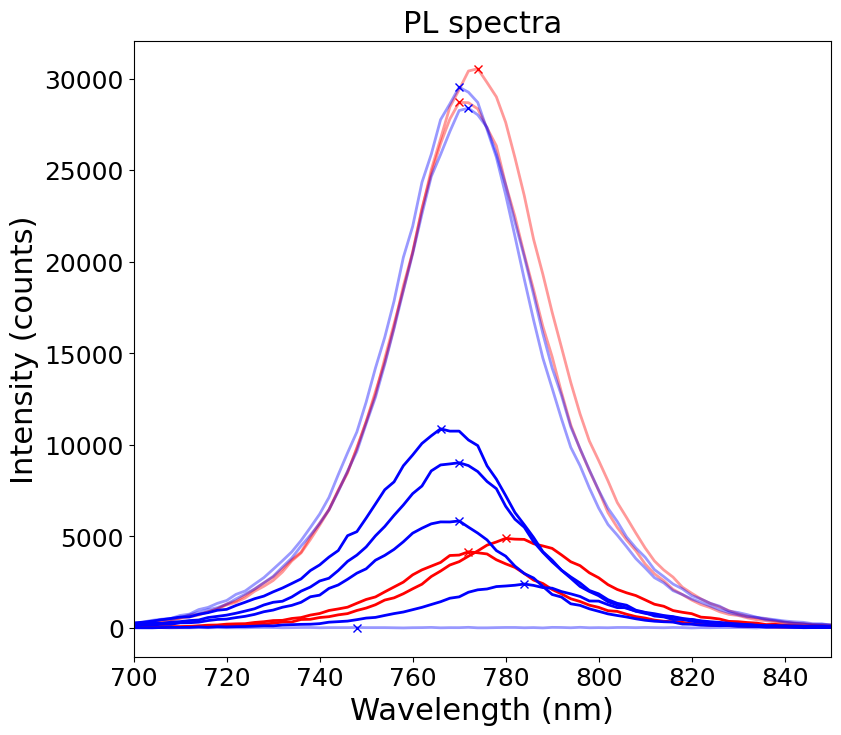

In [16]:
df_input_em2 = pd.DataFrame()
df_input_trpl2 = pd.DataFrame()
db = syre.Database(dev_root=r'C:\\Users\\fbaumann\\PyProjects_AMZ\\Project2\\data')
assets = db.find_assets()
main_assets = list(filter(lambda asset: asset.metadata["sample"]=='main', assets))
pl_assets = list(filter(lambda asset: asset.file.endswith("0.dat"), main_assets))
#xrd_01_assets = list(filter(lambda asset: '01' in asset.file, xrd_assets))
#xrd_02_assets = list(filter(lambda asset: '02' in asset.file, xrd_assets))
#xrd_03_assets = list(filter(lambda asset: '03' in asset.file, xrd_assets))

'''for ass in xrd_01_assets:
    new_frame = XRDframe(ass, light='dark', temp='RT')
    df_input = pd.concat([df_input, new_frame])
for ass in xrd_02_assets:
    new_frame = XRDframe(ass, light='1_sun', temp='RT')
    df_input = pd.concat([df_input, new_frame])'''
files = []
fig1 = plt.figure(figsize=(9, 8))  
ax1 = fig1.gca()
ax1.set_xlabel('Wavelength (nm)', fontsize=22)
ax1.set_ylabel('Intensity (counts)', fontsize=22)
ax1.set_title('PL spectra', fontsize=22)
ax1.set_xlim(700, 850)
ax1.tick_params(axis='both', labelsize=18)
for ass in pl_assets:
    print('Hej :' +ass.file)
    files.append(ass.file)
    type, new_frame, files = PLframe(ax1, files, ass, plot = False, l=2)
    if type == 'EM':
        df_input_em2 = pd.concat([df_input_em2, new_frame])
    elif type == 'TRPL':
        print('TRPL')
        df_input_trpl2 = pd.concat([df_input_trpl2, new_frame])
if df_input_trpl2.empty:
    df_input = df_input_em2
else:
    df_input = df_input_em2.merge(df_input_trpl2, on=['Sample','LOGG'], how='outer', indicator=True)

print(df_input)

In [17]:
#df_input.to_csv('PLTRPL_2.txt', sep='\t', index=False)

In [17]:
def PLframe1(ax1, files, ass, plot, l):
    file = ass.file
    var = ass.metadata['var']
    samp = ass.metadata['name']
    logg = ass.metadata['LOGG']
    if var == 'Ref':
        col = 'b'
    else: 
        col = 'r'
    if logg == 'after':
        alp = 0.9
    else:
        alp = 0.4
    if 'EM' in file: 
        data = read_PL_em(file)
        timestamp = pd.to_datetime(data['timestamp'], format='%m/%d/%Y %H:%M:%S')
        print(data['timestamp'])  # Check raw data format
        print(timestamp)  # Check converted format
        x = data['wavelength']
        y = data['intensity']
        y_bc = y - airpls(y)
        ax1, pos, intensity, shoulders = fit_PLem(ax1, x, y_bc,file, Fitplot=False, col = col, alp = alp, l=l)
        new_input = pd.DataFrame({
            'Sample': samp,
            'Variation': var,
            'LOGG': logg,
            'EM_time': timestamp,
            'EM_x':[x],
            'EM_y':[y], 
            'EM_lambda': pos,
            'EM_intensity': intensity,
            'EM_shoulders': [shoulders]
        })
        return 'EM', new_input, files
    elif 'TRPL' in file:
        data = read_TRPL(file)
        timestamp = pd.to_datetime(data['timestamp'], format='%m/%d/%Y %H:%M:%S')
        x = data['TRPL_ns']
        y = data['TRPL_intensity']
        y_bc = y - airpls(y, 10)
        params, fitted_curve, metrics, slope, intercept = fit_trpl(x, y_bc, model='triexponential', Fitplot=plot)
        if params is None:
            return 'TRPL', None, files
        new_input = pd.DataFrame({
            'Sample': samp,
            'Variation': var,
            'LOGG': logg,
            'TRPL_timestamp': timestamp,
            'TRPL_lambda': data['TRPL_lambda'],
            'TRPL_ns':[x],
            'TRPL_y':[y], 
            'TRPL_time': timestamp,
            'TRPL_a': params[0],
            'TRPL_b': params[1],
            'TRPL_metrics': [metrics], 
            'TRPL_iniSlope': slope,
            'TRPL_iniIntercept': intercept
        })
        return 'TRPL', new_input, files
    return

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20656\3127742743.py:22: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('Wavelength $\lambda$ (nm)', fontsize=22)


Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\MxRefThot1\data\Variation_Mod\DP17P1\After\BMKF20231010-DP17P1_EM_20231018-1753_0EM1.dat
10/18/2023 17:52:37
2023-10-18 17:52:37
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\MxRefThot1\data\Variation_Mod\DP17P1\Before\BMKF20231010-DP17P1_EM_20231017-1502_0EM1.dat
10/17/2023 15:01:40
2023-10-17 15:01:40
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\MxRefThot1\data\Variation_Mod\DP19P1\After\BMKF20231010-DP19P1_EM_20231018-1748_0EM1.dat
10/18/2023 17:48:06
2023-10-18 17:48:06
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\MxRefThot1\data\Variation_Mod\DP19P1\Before\BMKF20231010-DP19P1_EM_20231017-1524_0EM1.dat
10/17/2023 15:25:07
2023-10-17 15:25:07
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\MxRefThot1\data\Variation_Mod\DP19P2\After\BMKF20231010-DP19P2_EM_20231018-1805_0EM1.dat
10/18/2023 18:05:55
2023-10-18 18:05:55
Hej :\\?\C:\Users\fbaumann\PyProjects_AMZ\MxRefThot1\data\Variation_Mod\DP19P2\Before\BMKF20231010-DP19P2_EM_20231017-1529_0EM1.dat
10/17/2023 

C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20656\3127742743.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper left', fontsize=10)


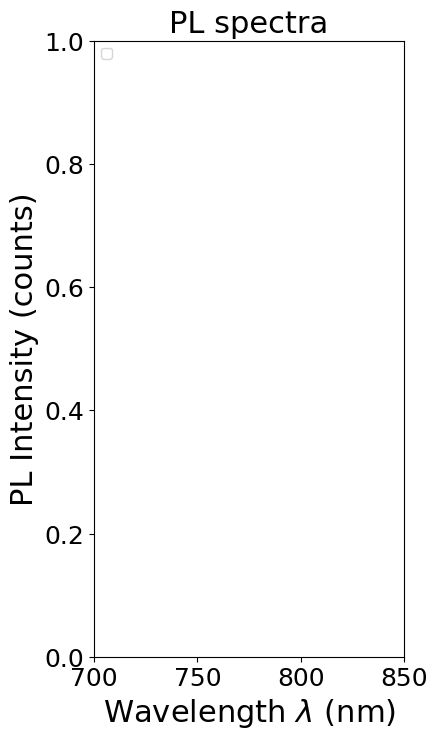

In [18]:
df_input_em = pd.DataFrame()
df_input_trpl = pd.DataFrame()
db = syre.Database(dev_root=r'C:\\Users\\fbaumann\\PyProjects_AMZ\\MxRefThot1\\data')
assets = db.find_assets()
main_assets = list(filter(lambda asset: asset.metadata["sample"]=='main', assets))
em1_pl_assets = list(filter(lambda asset: asset.file.endswith("0EM1.dat"), main_assets))
em2_pl_assets = list(filter(lambda asset: asset.file.endswith("0EM2.dat"), main_assets))
trpl_assets = list(filter(lambda asset: asset.file.endswith("0TRPL.dat"), main_assets))
#xrd_01_assets = list(filter(lambda asset: '01' in asset.file, xrd_assets))
#xrd_02_assets = list(filter(lambda asset: '02' in asset.file, xrd_assets))
#xrd_03_assets = list(filter(lambda asset: '03' in asset.file, xrd_assets))
pl_assets = em1_pl_assets + trpl_assets ##+ em2_pl_assets + 
'''for ass in xrd_01_assets:
    new_frame = XRDframe(ass, light='dark', temp='RT')
    df_input = pd.concat([df_input, new_frame])
for ass in xrd_02_assets:
    new_frame = XRDframe(ass, light='1_sun', temp='RT')
    df_input = pd.concat([df_input, new_frame])'''
files = []
fig1 = plt.figure(figsize=(4, 8))  
ax1 = fig1.gca()
ax1.set_xlabel('Wavelength $\lambda$ (nm)', fontsize=22)
ax1.set_ylabel('PL Intensity (counts)', fontsize=22)
ax1.set_title('PL spectra', fontsize=22)
ax1.set_xlim(700, 850)
ax1.tick_params(axis='both', labelsize=18)
for ass in pl_assets:
    print('Hej :' +ass.file)
    files.append(ass.file)
    type, new_frame, files = PLframe1(ax1, files, ass, plot = False, l=4)
    if type == 'EM':
        df_input_em = pd.concat([df_input_em, new_frame])
    elif type == 'TRPL':
        print('TRPL')
        df_input_trpl = pd.concat([df_input_trpl, new_frame])
if df_input_trpl.empty:
    df_input = df_input_em
else:
    df_input = df_input_em.merge(df_input_trpl, on=['Sample','LOGG'], how='outer', indicator=True)
ax1.legend(loc='upper left', fontsize=10)
print(df_input)

        Sample Variation_x    LOGG             EM_time  \
0     1p1discm         Ref   after 2023-10-17 18:24:33   
1     1p1discm         Ref  before 2023-10-16 17:26:51   
2       DP12P1         Ref   after 2023-10-17 17:34:11   
3       DP12P1         Ref  before 2023-10-16 17:03:44   
4       DP12P2         Ref   after 2023-10-17 17:50:32   
5       DP12P2         Ref  before 2023-10-16 17:10:30   
6      DP16P2m         Ref   after 2023-10-17 18:14:23   
7      DP16P2m         Ref  before 2023-10-16 10:35:56   
8       DP17P1         Mod   after 2023-10-18 17:52:37   
9       DP17P1         Mod  before 2023-10-17 15:01:40   
10      DP19P1         Mod   after 2023-10-18 17:48:06   
11      DP19P1         Mod  before 2023-10-17 15:25:07   
12      DP19P2         Mod   after 2023-10-18 18:05:55   
13      DP19P2         Mod  before 2023-10-17 15:29:19   
14      DP1P2m         Ref   after 2023-10-17 17:39:26   
15      DP1P2m         Ref  before 2023-10-16 17:30:55   
16      DP20P2

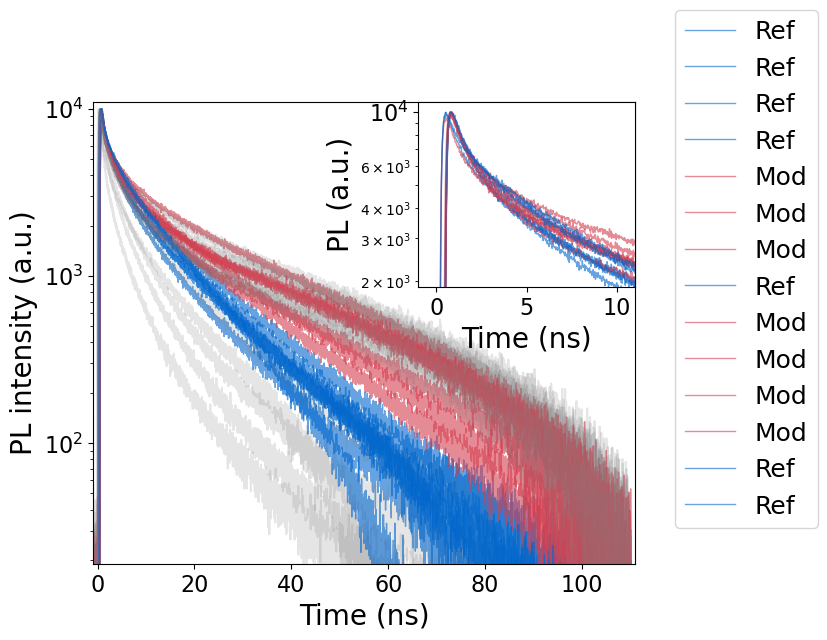

In [19]:
fig = plt.figure(figsize=(7, 6))
ax = fig.gca()
colors = {'Ref': '#0066CC',  # Blue
          'Mod': '#D53E4F'}  # Red
alphas = {'after': 0.6,  # Blue
          'before': 0.2}  # Red
axins = ax.inset_axes([0.6, 0.6, 0.4, 0.4])
#axins2 = ax.inset_axes([0.8, 0.4, 0.15, 0.6])

print(df_input)
for sample in df_input['Sample'].unique():
    print(sample)
    samp_df = df_input[df_input['Sample'] == sample]
    for state in samp_df['LOGG'].unique():
        print(state)
        stat = samp_df[samp_df['LOGG'] == state]
        x = stat['TRPL_ns'].iloc[0]
        y = stat['TRPL_y'].iloc[0]
        baseline = y[0:103].mean()
        y_bc = y - baseline
        var = stat['Variation_x'].iloc[0]
        if var == 'Ref':
            if state == 'after':
                print(sample, state)
                axins.plot(x-2.3, y_bc, color=colors[var], lw=1, alpha=alphas[stat['LOGG'].iloc[0]])
                ax.plot(x-2.3, y_bc, color=colors[var], lw=1, alpha=alphas[stat['LOGG'].iloc[0]], label = var)
                #axins2.plot(x-2.3, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
            else:
                ax.plot(x-2.6, y_bc, color='grey', alpha=alphas[stat['LOGG'].iloc[0]])
                i=0#   #
                #axins.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
                #axins2.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
        else: 
            if state == 'after':
                axins.plot(x-2.3, y_bc, color=colors[var], lw=1, alpha=alphas[stat['LOGG'].iloc[0]])
                ax.plot(x-2.3, y_bc, color=colors[var], lw=1, alpha=alphas[stat['LOGG'].iloc[0]], label = var)
                #axins2.plot(x-2.3, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
            else:
                ax.plot(x-2.6, y_bc, color='gray', alpha=alphas[stat['LOGG'].iloc[0]])
                i=0#   #
                #axins.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
                #axins2.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
ax.set_yscale('log')
ax.set_ylim(1.9e1,1.1e4)
ax.set_xlim(-1,111)
ax.set_xlabel('Time (ns)', fontsize=20)
ax.set_ylabel('PL intensity (a.u.)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
axins.set_yscale('log')
axins.set_ylim(1.9e3,1.1e4)
axins.set_xlim(-1,11)
axins.set_xlabel('Time (ns)', fontsize=20)
axins.set_ylabel('PL (a.u.)', fontsize=20)
axins.tick_params(axis='both', which='major', labelsize=16)

'''axins2.set_yscale('log')
axins2.set_ylim(6e3,1e4)
axins2.set_xlim(0.05,2.2)
axins2.set_xlabel('Time (ns)', fontsize=12)'''
ax.legend(loc='lower left', fontsize=18, bbox_to_anchor=(1.05, 0.05))

df_input.to_csv('MRdata.csv', sep='\t', index=False)

        Sample Variation_x    LOGG             EM_time  \
0     1p1discm         Ref   after 2023-10-17 18:24:33   
1     1p1discm         Ref  before 2023-10-16 17:26:51   
2       DP12P1         Ref   after 2023-10-17 17:34:11   
3       DP12P1         Ref  before 2023-10-16 17:03:44   
4       DP12P2         Ref   after 2023-10-17 17:50:32   
5       DP12P2         Ref  before 2023-10-16 17:10:30   
6      DP16P2m         Ref   after 2023-10-17 18:14:23   
7      DP16P2m         Ref  before 2023-10-16 10:35:56   
8       DP17P1         Mod   after 2023-10-18 17:52:37   
9       DP17P1         Mod  before 2023-10-17 15:01:40   
10      DP19P1         Mod   after 2023-10-18 17:48:06   
11      DP19P1         Mod  before 2023-10-17 15:25:07   
12      DP19P2         Mod   after 2023-10-18 18:05:55   
13      DP19P2         Mod  before 2023-10-17 15:29:19   
14      DP1P2m         Ref   after 2023-10-17 17:39:26   
15      DP1P2m         Ref  before 2023-10-16 17:30:55   
16      DP20P2

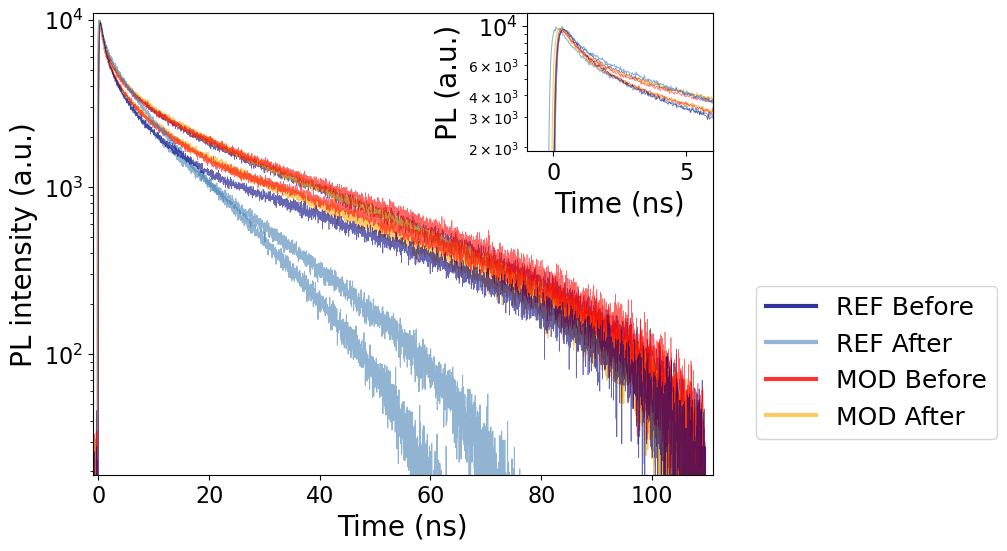

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
colarray = ['red', 'orangered']
colarray = ['navy', 'steelblue',]

colors = {'Ref': 'steelblue',#0066CC',  # Blue
          'Mod': 'orange'}#'crimson'}  # Red  #D53E4F
alphas = {'after': 0.6,  # Blue
          'before': 0.9}  # Red
axins = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
#axins2 = ax.inset_axes([0.8, 0.4, 0.15, 0.6])

print(df_input)
for sample in df_input['Sample'].unique():
    print(sample)
    samp_df = df_input[df_input['Sample'] == sample]
    for state in samp_df['LOGG'].unique():
        print(state)
        stat = samp_df[samp_df['LOGG'] == state]
        x = stat['TRPL_ns'].iloc[0]
        y = stat['TRPL_y'].iloc[0]
        baseline = y[0:103].mean()
        y_bc = y - baseline
        var = stat['Variation_x'].iloc[0]
        if var == 'Ref':
            if state != 'after':
                if sample == 'DP6P2' or sample =='DP16P2m':  #sample ==  or 'DP1P2m'#
                    ax.plot(x-2.7, y_bc, color='navy', lw = 0.5, alpha=0.6)
                    axins.plot(x-2.7, y_bc, color='navy', lw = 0.5, alpha=0.6)
                i=0#
                #axins2.plot(x-2.3, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
            else:
                if sample == 'DP16P2m':
                    axins.plot(x-2.7, y_bc, color=colors[var], lw=0.8, alpha=alphas[stat['LOGG'].iloc[0]])
                    ax.plot(x-2.7, y_bc, color=colors[var], lw=0.8, alpha=alphas[stat['LOGG'].iloc[0]])
                if sample =='DP6P2': #sample == 'DP16P2m'
                    axins.plot(x-2.5, y_bc, color=colors[var], lw=0.8, alpha=alphas[stat['LOGG'].iloc[0]])
                    ax.plot(x-2.5, y_bc, color=colors[var], lw=0.8, alpha=alphas[stat['LOGG'].iloc[0]])   #
                #axins.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
                #axins2.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
        else: 
            if state != 'after':
                if sample == 'DP19P2' or sample == 'DP20P2': #or sample == 'DP17P1' 
                    ax.plot(x-2.8, y_bc, color='red', lw = 0.5, alpha=0.6)
                    axins.plot(x-2.8, y_bc, color='red', lw = 0.5, alpha=0.6)
                i=0#   #
            else:
                if sample == 'DP19P1' or sample == 'DP20P2':  #or sample == 'DP17P1'
                    axins.plot(x-2.8, y_bc, color=colors[var], lw=0.8, alpha=alphas[stat['LOGG'].iloc[0]])
                    ax.plot(x-2.8, y_bc, color=colors[var], lw=0.8, alpha=alphas[stat['LOGG'].iloc[0]])
                #axins2.plot(x-2.3, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
                #axins.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
                #axins2.plot(x-2.6, y_bc, color=colors[var], alpha=alphas[stat['LOGG'].iloc[0]])
ax.set_yscale('log')
ax.set_ylim(1.9e1,1.1e4)
ax.set_xlim(-1,111)
ax.set_xlabel('Time (ns)', fontsize=20)
ax.set_ylabel('PL intensity (a.u.)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
axins.set_yscale('log')
axins.set_ylim(1.9e3,1.2e4)
axins.set_xlim(-1,6)
axins.set_xlabel('Time (ns)', fontsize=20)
axins.set_ylabel('PL (a.u.)', fontsize=20)
axins.tick_params(axis='both', which='major', labelsize=16)

ax.plot([], [], color='navy', lw=3, alpha=0.8, label = 'REF Before')
ax.plot([], [], color='steelblue', lw=3, alpha=0.6, label = 'REF After')
ax.plot([], [], color='red', lw=3, alpha=0.8, label = 'MOD Before')
ax.plot([], [], color='orange', lw=3, alpha=0.6, label = 'MOD After')

'''axins2.set_yscale('log')
axins2.set_ylim(6e3,1e4)
axins2.set_xlim(0.05,2.2)
axins2.set_xlabel('Time (ns)', fontsize=12)'''
ax.legend(loc='lower left', fontsize=18, bbox_to_anchor=(1.05, 0.05))

df_input.to_csv('MRdata.csv', sep='\t', index=False)

In [20]:
#df_input.to_csv('PLTRPLMxRef1.txt', sep='\t', index=False)

In [149]:

res_df= pd.DataFrame()
for samp in df_input['Sample'].unique():
    print(samp)
    sample_df= df_input[df_input['Sample']==samp]
    for state in sample_df['LOGG'].unique():
        print(state)
        state_df = sample_df[sample_df['LOGG']==state]
        ti = []
        for time in state_df['EM_time'].unique():
            #print(time)
            tim = state_df[state_df['EM_time']==time]
            ti.append(tim['EM_lambda'].values[0])
            print(ti)
        if len(ti) > 1:
            mean = np.mean(ti)
            diff = np.diff(ti)
        else: 
            ti.append(ti[0])
            mean = ti[0]
            diff = 'NA'
        #print(samp, state, ti, diff, mean)
        new_line = pd.DataFrame({'Variation': [tim['Variation_x'].iloc[0]], 
                                 'Sample':samp, 
                                 'Time':tim['EM_time'].iloc[0], 
                                 'LOGG':state, 
                                 't1': ti[0], 
                                 't2':ti[1], 
                                 'mean':mean, 
                                 'diff':diff[0]
                                 })  
        res_df = pd.concat([res_df, new_line], ignore_index=True)
print(res_df)

DP22P1
after
[775.9999789414]
before
[781.999972332414]
DP6P2
after
[768.000006701186]
before
[778.000014634017]
  Variation  Sample                Time    LOGG          t1          t2  \
0       Mod  DP22P1 2023-10-18 17:56:44   after  775.999979  775.999979   
1       Mod  DP22P1 2023-10-16 17:19:43  before  781.999972  781.999972   
2       Ref   DP6P2 2023-10-17 17:45:34   after  768.000007  768.000007   
3       Ref   DP6P2 2023-10-16 09:56:39  before  778.000015  778.000015   

         mean diff  
0  775.999979    N  
1  781.999972    N  
2  768.000007    N  
3  778.000015    N  


[5.99999339]
[10.00000793]
[5.999993391014073]
[10.000007932831068]


<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_1576\1666373640.py:37: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('$\Delta$ EM lambda (nm) mean', fontsize=12)


[Text(0, 0, 'Mod'), Text(1, 0, 'Ref')]

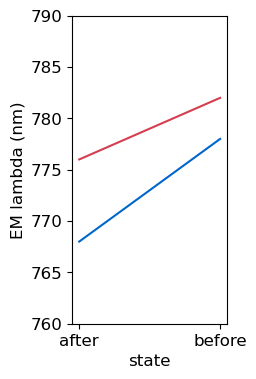

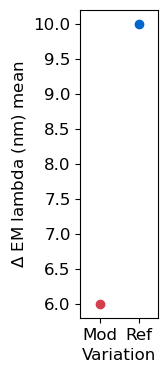

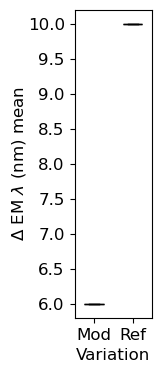

In [150]:
# Define your desired order
#tick_positions = [1, 2]
#tick_labels = ['before', 'after']

fig = plt.figure(figsize=(2,4))
ax = fig.gca()
fig2 = plt.figure(figsize=(1,4))
ax2 = fig2.gca()
fig3 = plt.figure(figsize=(1,4))
ax3 = fig3.gca()
colors = {'Ref': '#0066CC',  # Blue
          'Mod': '#D53E4F'}  # Red

y_mod=[]
y_ref=[]


for sample in res_df['Sample'].unique():
    samp = res_df[res_df['Sample'] == sample]
    d = samp['mean'].values
    diffy = np.diff(d)
    print(diffy)
    ax.plot(samp['LOGG'], samp['mean'], color=colors[samp['Variation'].iloc[0]])
    ax2.scatter(samp['Variation'].iloc[0], diffy, color=colors[samp['Variation'].iloc[0]])
    if samp['Variation'].iloc[0] == 'Mod':
        y_mod.append(diffy[0])
    else:
        y_ref.append(diffy[0])

ax.set_ylim(760, 790)
ax.set_xlabel('state', fontsize=12)
ax.set_ylabel('EM lambda (nm)', fontsize=12)
ax.tick_params(axis='both', which='major',labelsize=12)

ax2.set_xlim([-0.5, 1.5])
ax2.set_xlabel('Variation', fontsize=12)
ax2.set_ylabel('$\Delta$ EM lambda (nm) mean', fontsize=12)
ax2.tick_params(axis='both', which='major',labelsize=12)

print(y_mod)
print(y_ref)

ax3.boxplot(y_mod, positions=[0],widths=0.5, patch_artist=True, boxprops=dict(facecolor='red'), medianprops=dict(color="black"))
ax3.boxplot(y_ref, positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color="black"))
ax3.set_xlim([-0.5, 1.5])
ax3.set_xlabel('Variation', fontsize=12)
ax3.set_ylabel(r'$\Delta$ EM $\lambda$ (nm) mean', fontsize=12, labelpad=-0.2)
ax3.tick_params(axis='both', which='major',labelsize=12)
ax3.set_xticklabels(['Mod', 'Ref'])


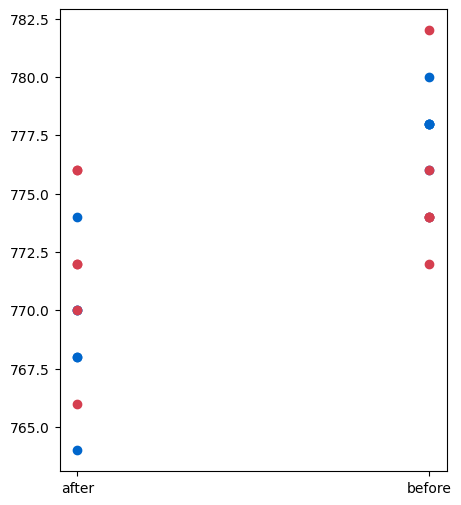

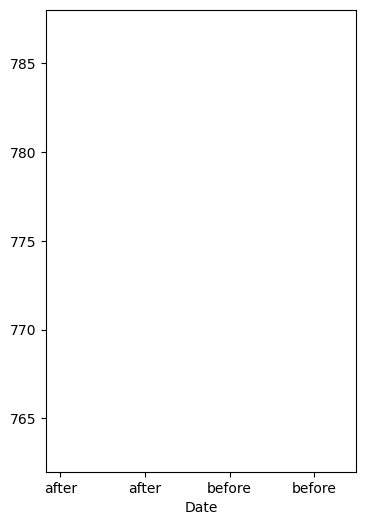

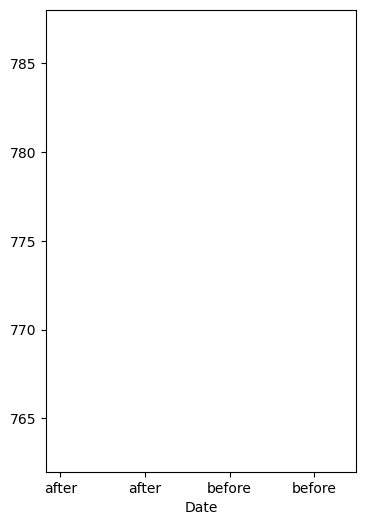

In [76]:
fig = plt.figure(figsize=(5, 6))
ax = fig.gca()
colors = {'Ref': '#0066CC',  # Blue
          'Mod': '#D53E4F'}  # Red

for var in res_df['Variation'].unique():
    fig2 = plt.figure(figsize=(4, 6))
    ax2 = fig2.gca()
    df_var = res_df[res_df['Variation'] == var]
    ax.scatter(df_var['LOGG'], df_var['t1'], color=colors[df_var['Variation'].iloc[0]])
    ax2.scatter(df_var['LOGG'], df_var['diff'], alpha=0.5, color=colors[df_var['Variation'].iloc[0]])
    ax2.set_xlabel('Date')
    #ax2.set_xlim(pd.Timestamp('2023-10-16 08:00:00'), pd.Timestamp('2023-10-18 20:00:00'))
    ax2.xaxis.set_major_locator(MaxNLocator(4))
    ax2.set_ylim(762, 788)





from matplotlib.ticker import MaxNLocator





In [20]:
help(plt.boxplot)

Help on function boxplot in module matplotlib.pyplot:

boxplot(x: 'ArrayLike | Sequence[ArrayLike]', notch: 'bool | None' = None, sym: 'str | None' = None, vert: 'bool | None' = None, whis: 'float | tuple[float, float] | None' = None, positions: 'ArrayLike | None' = None, widths: 'float | ArrayLike | None' = None, patch_artist: 'bool | None' = None, bootstrap: 'int | None' = None, usermedians: 'ArrayLike | None' = None, conf_intervals: 'ArrayLike | None' = None, meanline: 'bool | None' = None, showmeans: 'bool | None' = None, showcaps: 'bool | None' = None, showbox: 'bool | None' = None, showfliers: 'bool | None' = None, boxprops: 'dict[str, Any] | None' = None, tick_labels: 'Sequence[str] | None' = None, flierprops: 'dict[str, Any] | None' = None, medianprops: 'dict[str, Any] | None' = None, meanprops: 'dict[str, Any] | None' = None, capprops: 'dict[str, Any] | None' = None, whiskerprops: 'dict[str, Any] | None' = None, manage_ticks: 'bool' = True, autorange: 'bool' = False, zorder: '

    Sample Variation_x    LOGG             EM_time  \
0   DP12P1         Ref   after 2023-10-17 17:34:11   
1   DP12P1         Ref   after 2023-10-17 17:37:39   
2   DP12P1         Ref  before 2023-10-16 17:03:44   
3   DP12P1         Ref  before 2023-10-16 17:08:16   
4   DP12P2         Ref   after 2023-10-17 17:50:32   
5   DP12P2         Ref   after 2023-10-17 18:12:45   
6   DP12P2         Ref  before 2023-10-16 17:10:30   
7   DP12P2         Ref  before 2023-10-16 17:13:34   
8   DP16P2         Ref   after 2023-10-17 18:14:23   
9   DP16P2         Ref   after 2023-10-17 18:17:37   
10  DP16P2         Ref  before 2023-10-16 10:35:56   
11  DP16P2         Ref  before 2023-10-16 10:41:24   
12  DP17P1         Mod   after 2023-10-18 17:52:37   
13  DP17P1         Mod   after 2023-10-18 17:55:12   
14  DP17P1         Mod  before 2023-10-17 15:01:40   
15  DP17P1         Mod  before 2023-10-17 15:04:23   
16  DP19P1         Mod   after 2023-10-18 17:48:06   
17  DP19P1         Mod   aft

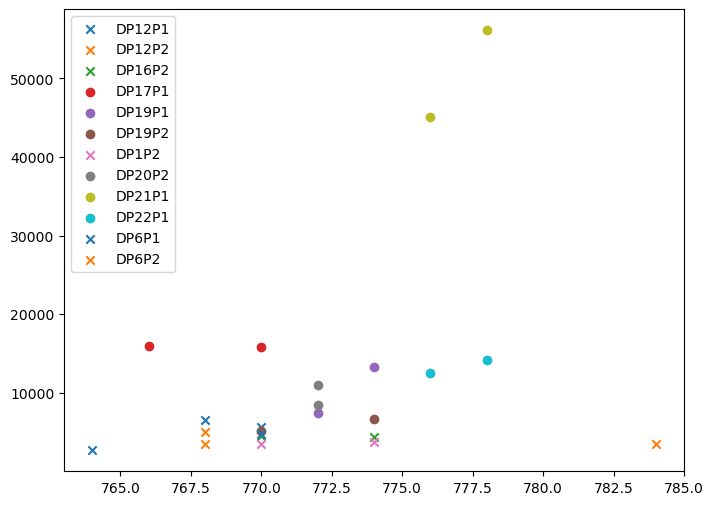

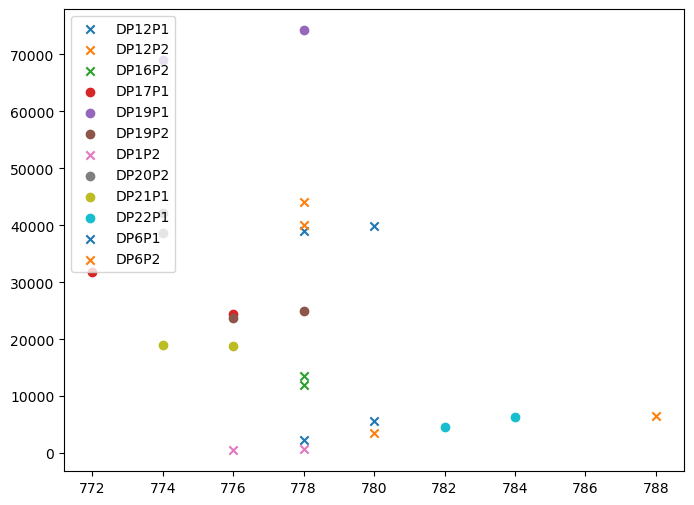

In [27]:
print(df_input)
for state in df_input['LOGG'].unique():
    df_state = df_input[df_input['LOGG'] == state]
    print(df_state)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca()
    for sample in df_state['Sample'].unique():
        df_sample = df_state[df_state['Sample'] == sample]
        if df_sample['Variation_x'].iloc[0] == 'Mod':
            ax.scatter(df_sample['EM_lambda'], df_sample['EM_intensity'],  marker='o', label=sample)
        else:
            ax.scatter(df_sample['EM_lambda'], df_sample['EM_intensity'], marker='x', label=sample)
        ax.legend(loc = 'upper left')

In [22]:
#Here we read in all the raw data
import syre 
import pandas as pd

import chardet

#with open(r'C:\\Users\\fbaumann\\PyProjects_AMZ\\Project2\\data\\MOD\\DP16P1\\Before\\BMKP2_DP16P1before_EM_20250127_1433_0.dat', 'rb') as file:
#    raw_data = file.read()
#    result = chardet.detect(raw_data)
#   print(result)

In [ ]:
    '''
    amplitudes = []
    centers = []
    stddevs = []
    peak_count = 0  # Counter to track the number of peaks found
    threshold_y = y_thres  # Threshold for peak identification in y-direction
    min_distance_x = min_xdelta  # Minimum distance between peaks in x-direction
    low_threshold_x = low_Xthres
    up_threshold_x = high_Xthres
    last_peak_x = low_Xthres
    #estimated_background = als(y_array)
    estimated_background = airpls(y_array)
    #plt.plot(x_array,estimated_background, color='r')    #Uncomment to plot the background corrected spectra
    #estimated_background = np.convolve(y_array, np.ones(len(y_array))/(len(y_array)), mode='same') #This was the old background correction
    y_bc_array = y_array-estimated_background
    indices_beyond_threshold = []
    for i in range(x_array.size): 
        if x_array[i] < up_threshold_x: # Stop BEFORE going beyond scan
            if x_array[i] > low_threshold_x:
                indices_beyond_threshold.append(i)
    for i in indices_beyond_threshold:
        if (y_bc_array[i-3] < y_bc_array[i] > y_bc_array[i+5]) and y_bc_array[i] > threshold_y:
            center, amplitude, wsum = fit_to_peak(x_array[i-10:i+10], y_bc_array[i-10:i+10], Fitplot)
            #print(center,amplitude,wsum)
            if center == None :
                continue
            elif center > low_threshold_x:
                if peak_count == 0: 
                    peak_count += 1
                    amplitudes.append(amplitude)
                    centers.append(center)
                    stddevs.append(wsum)
                    last_peak_x = center
                elif (center-last_peak_x) < min_distance_x: # Check minimum distance between peaks in x-direction
                    if wsum < stddevs[peak_count-1]:      #if amplitude > amplitudes[peak_count-1]:
                        amplitudes[peak_count-1] = amplitude
                        centers[peak_count-1] = center
                        stddevs[peak_count-1] = wsum
                        last_peak_x = center
                    continue
                else: 
                    peak_count += 1
                    if peak_count == maxpeaks+1:  # Stop if finding too many peaks
                        break
                    amplitudes.append(amplitude)
                    centers.append(center)
                    stddevs.append(wsum)
                    last_peak_x = center'''
    return centers, amplitudes, stddevs, peak_count

In [2]:

'''
        data = df[df['start_time']==time]
        end = data['end_time'].iloc[0]
        rel_a = data['rel_a'].iloc[0]
        #print(sample['Variation'].iloc[0])
        #a_rel = df_xshift[df_xshift['Sample']==samp]['a_rel'].iloc[0]
        x_array = data['x_array'].iloc[0]
        y_array = data['y_array'].iloc[0]
        x_parray = np.array(x_array)
        y_parray = np.array(y_array)
        plt.plot(x_parray, y_parray)
        centers, amplitudes, stddevs, peak_count = fit_XRD(x_parray, y_parray, low, high, max, y_thres=ythres, Fitplot=pl) 
        #print(center)
        peaks = []
        d_values=[]
        for center in centers: 
            i = 0
            peak = None
            while i < len(peak_names):
                if peak_ranges[i][0] < center < peak_ranges[i][1]:
                    peak = peak_names[i]
                    if peak == 'FTO(110)':
                        rel_a = (a_value(braggs(center), 1, 1, 0))/ref_ftoAvalue
                i+=1
            if peak == None: 
                peak = 'Unknown'
            d = braggs(center)
            d_values.append(d)
            peaks.append(peak)
        new_sample_df = pd.DataFrame({
            'start_time': time, 
            'end_time': end,    
            'light': data['light'].iloc[0],
            'temp': data['temperature'].iloc[0],
            'sample': data['Sample'].iloc[0],
            'Peak': peaks,
            'pos': centers,
            'amplitude': amplitudes,
            'stdvG': stddevs, 
            'd_value': d_values,
            'rel_a': rel_a
        })
        result_df = pd.concat([result_df, new_sample_df])
    return result_df'''


"\n        data = df[df['start_time']==time]\n        end = data['end_time'].iloc[0]\n        rel_a = data['rel_a'].iloc[0]\n        #print(sample['Variation'].iloc[0])\n        #a_rel = df_xshift[df_xshift['Sample']==samp]['a_rel'].iloc[0]\n        x_array = data['x_array'].iloc[0]\n        y_array = data['y_array'].iloc[0]\n        x_parray = np.array(x_array)\n        y_parray = np.array(y_array)\n        plt.plot(x_parray, y_parray)\n        centers, amplitudes, stddevs, peak_count = fit_XRD(x_parray, y_parray, low, high, max, y_thres=ythres, Fitplot=pl) \n        #print(center)\n        peaks = []\n        d_values=[]\n        for center in centers: \n            i = 0\n            peak = None\n            while i < len(peak_names):\n                if peak_ranges[i][0] < center < peak_ranges[i][1]:\n                    peak = peak_names[i]\n                    if peak == 'FTO(110)':\n                        rel_a = (a_value(braggs(center), 1, 1, 0))/ref_ftoAvalue\n               

In [303]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(result_df)

     Sample      Temp                Time  intercept
0  7P1onOFF  ecovery. 2025-01-31 10:02:14   6.278685
0  7P1onOFF  dark_RT. 2025-01-30 17:57:03   6.287068
0  7P1onOFF  SM_L_85. 2025-01-30 18:43:59   6.308909
0  7P1onOFF  dark_RT. 2025-01-30 19:30:54   6.275476
0  7P1onOFF  SM_L_85. 2025-01-30 20:17:50   6.309293
0  7P1onOFF  dark_RT. 2025-01-30 21:04:46   6.277172
0  7P1onOFF  SM_L_85. 2025-01-30 21:51:42   6.309275
0  7P1onOFF  dark_RT. 2025-01-30 22:38:38   6.277955


<>:45: SyntaxWarning: invalid escape sequence '\T'
<>:45: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_18996\3085203328.py:45: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


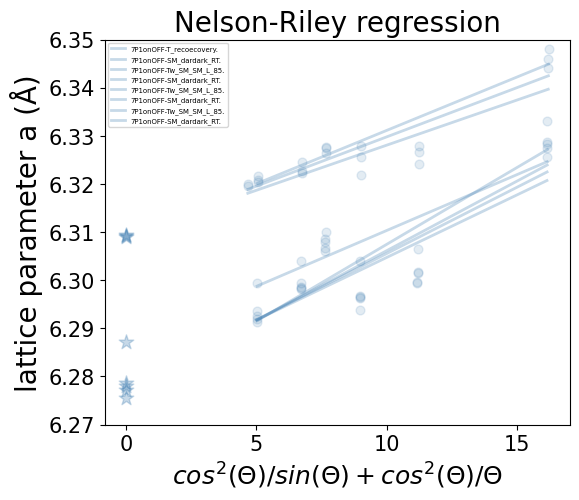

In [304]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red','green', 'darkorange', 'navy','green','orange','black','grey', 'indigo']
col_ind = 0
nr = pd.DataFrame()
for device in result_df['sample'].unique():   
    temps_array = []
    temp_count = 0
    data = result_df[result_df['sample']==device]
    '''if device == '16P2':
        col_ind = 1
    else: 
        col_ind = 0'''
    for time in data['start_time'].unique():
        dat = data[data['start_time']==time]
        temp = dat['temp'].iloc[0]
        mid_time = datetime.fromtimestamp(np.round(dat['start_time'].iloc[0].timestamp() + (dat['end_time'].iloc[0].timestamp() - dat['start_time'].iloc[0].timestamp())/2))        
        '''if temp in temps_array: 
            if temp_count > len(temps_array):
                continue
            alf = 0.5
            temp_count += 1
        else: 
            col_ind+=1
            temps_array.append(temp)
            if 'L' in dat['temp'].iloc[0]:
                alf = 0.9
            else: 
                alf = 0.6 - len(temps_array)*0.08'''
        c, samp = nelson_riley(dat, ax, col_array[col_ind], 'a_raw', 'pos', alp=0.3, lab=dat['sample'].iloc[0]+'-'+dat['light'].iloc[0]+str(dat['temp'].iloc[0]))
        nr_new = pd.DataFrame({
            'Sample':samp, 
            'Temp':temp, 
            'Time':mid_time, 
            'intercept':c
            })
        nr = pd.concat([nr, nr_new])
    col_ind += 1

ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
ax.set_ylim(6.27,6.35)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper left', fontsize=5)  
print(nr)



In [305]:
light1_asset = list(filter(lambda asset: asset.file.endswith("light.txt"), main_assets))[0]
#light2_asset = list(filter(lambda asset: asset.file.endswith("light20.txt"), main_assets))[0]
temp1_asset = list(filter(lambda asset: asset.file.endswith("temp.txt"), main_assets))[0]
#temp2_asset = list(filter(lambda asset: asset.file.endswith("temp20.txt"), main_assets))[0]
temp_df = pd.read_csv(temp1_asset.file, delimiter="\t")
#temp2_df = pd.read_csv(temp2_asset.file, delimiter="\t")
#temp_df = pd.concat([temp1_df, temp2_df], axis = 0, ignore_index=True)
light_df = pd.read_csv(light1_asset.file, delimiter="\t")
#light2_df = pd.read_csv(light2_asset.file, delimiter="\t")
#light_df = pd.concat([light1_df, light2_df], axis = 0, ignore_index=True)

temp_df = pd.concat([pd.to_datetime(temp_df['Date'] + ' ' + temp_df['RealTime']).rename('Time'), temp_df], axis = 1)
light_df = pd.concat([pd.to_datetime(light_df['Date'] + ' ' + light_df['RealTime']).rename('Time'), light_df], axis = 1)

light_df['Light'] = np.where(light_df['Corriente'] > 200e-3, 'ON', 'OFF')
temp_df['Heat_state'] = np.where(temp_df['set_TEMP'] > 0, 'HIGH', 'LOW')
# Calculate seconds since start for all dataframes
start_time = temp_df['Time'].min()
# Convert to seconds since start
temp_df['Seconds'] = (temp_df['Time'] - start_time).dt.total_seconds()
nr['Seconds'] = (nr['Time'] - start_time).dt.total_seconds()
light_df['Seconds'] = (light_df['Time'] - start_time).dt.total_seconds()


print(light_df)
print(temp_df)

                     Time  Counter        Date  RealTime  TimeDouble  \
0     2025-01-30 18:17:56        0  01-30-2025  18:17:56    4008.419   
1     2025-01-30 18:17:57        1  01-30-2025  18:17:57    4009.485   
2     2025-01-30 18:17:58        2  01-30-2025  18:17:58    4010.509   
3     2025-01-30 18:17:59        3  01-30-2025  18:17:59    4011.533   
4     2025-01-30 18:18:00        4  01-30-2025  18:18:00    4012.557   
...                   ...      ...         ...       ...         ...   
54850 2025-01-31 10:31:11    54850  01-31-2025  10:31:11   62403.650   
54851 2025-01-31 10:31:12    54851  01-31-2025  10:31:12   62404.670   
54852 2025-01-31 10:31:13    54852  01-31-2025  10:31:13   62405.690   
54853 2025-01-31 10:31:14    54853  01-31-2025  10:31:14   62406.720   
54854 2025-01-31 10:31:15    54854  01-31-2025  10:31:15   62407.740   

        Voltage     Corriente   Resistance Light  Seconds  
0     -0.000024  6.342660e-08     -376.648   OFF   4009.0  
1     -0.000031

0     LOW
0     LOW
0    HIGH
0     LOW
0    HIGH
0     LOW
0    HIGH
0     LOW
Name: Heat_state, dtype: object


IndexError: list index out of range

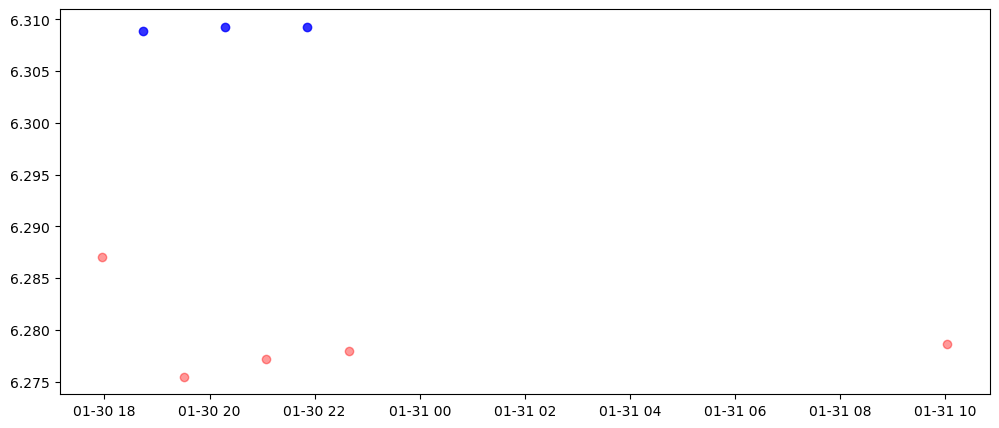

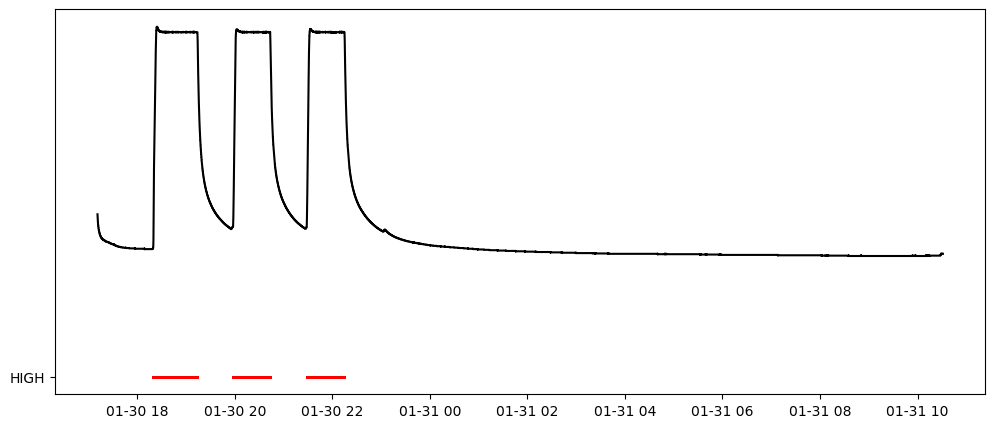

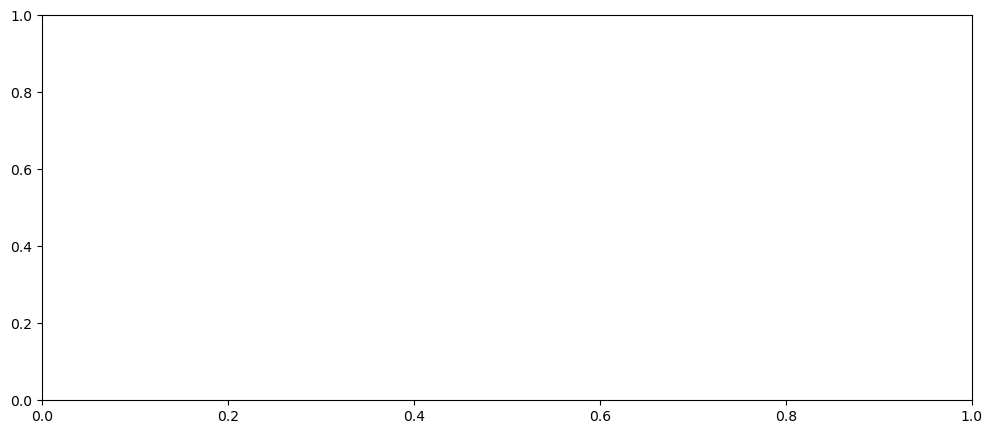

In [306]:
import matplotlib.dates as mdates
from datetime import timedelta

fig1 = plt.figure(figsize=(12,5))
ax1 = fig1.gca()
fig2 = plt.figure(figsize=(12,5))
ax2 = fig2.gca()
fig3 = plt.figure(figsize=(12,5))
ax3 = fig3.gca()

color_array = ['red', 'blue', 'green', 'indigo', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'steelblue', 'gold', 'darkred', 'darkblue', 'darkgreen', 'darkmagenta', 'darkorange', 'darkviolet', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darksteelblue', 'darkgold', 'olive', 'green', 'blue', 'red', 'indigo', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'steelblue', 'gold', 'darkred', 'darkblue', 'darkgreen', 'darkmagenta', 'darkorange', 'darkviolet', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darksteelblue', 'darkgold']
alpha_array = [0.4, 0.8]
i_L = 0
i_T = 0
L = 'OFF'
T = 'LOW'
nr['measured_temp'] = nr['Time'].map(lambda x: temp_df.loc[(temp_df['Time'] - x).abs().idxmin(), 'Temperature'])
nr['Heat_state'] = nr['Time'].map(lambda x: temp_df.loc[(temp_df['Time'] - x).abs().idxmin(), 'Heat_state'])
print(nr['Heat_state'])
# Get light state at nr times
nr['light_state'] = nr['Time'].map(lambda x: light_df.loc[(light_df['Time'] - x).abs().idxmin(), 'Light'])


for time in nr['Time'].unique():
    data = nr[nr['Time']==time]
    if data['Heat_state'].iloc[0] == 'HIGH':
        T = 'HIGH'
        i_T = 1
    else:
        T = 'LOW'
        i_T = 0
    if data['light_state'].iloc[0] == 'ON':
        L = 'ON'
        i_L = 1
    else:
        L = 'OFF'
        i_L = 0
    ax1.scatter(data['Time'], data['intercept'], color = color_array[i_T], alpha=alpha_array[i_L])
    #ax1.scatter(data['Time'], data['measured_temp'], color = color_array[i])
    #i+=1  
    #ax1.scatter(data['Time'], data['light_state'], color = color_array[i])
    #i = 0

heat_mask = temp_df['Heat_state'] == 'HIGH'
ax2.plot(temp_df['Time'], temp_df['Temperature'], color = 'k')
ax2.scatter(temp_df.loc[heat_mask,'Time'], temp_df.loc[heat_mask,'Heat_state'], color = 'r', s = 1)
#if temp_df['Time']['Heating'].iloc[0] != 'state':

#    'state' = temp_df['Time']['Heating'].iloc[0]
ax3.plot(light_df['Time'], light_df['Light'], color = color_array[i])
#i +=1
#ax1.legend(loc='lower left')
#ax1.set_xlim(min(peak_df['start_time']), min(peak_df['start_time'])+timedelta(hours=11))
#ax1.set_ylim(6.21, 6.37)
ax1.set_xlabel('Time (HH:MM)', fontsize = 20)
ax1.set_ylabel('Cell parameter a (Å)', fontsize = 20)
#ax2.set_xlim(min(peak_df['start_time']), min(peak_df['start_time'])+timedelta(hours=11))
#ax2.legend()
locator = mdates.AutoDateLocator()  # Automatically adjust ticks based on the data range
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_formatter(formatter)
ax2.set_xlabel('Time (HH:MM)', fontsize = 20)
ax2.set_ylabel('Temperature', fontsize = 20)
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax3.xaxis.set_major_formatter(formatter)
#ax3.set_xlim(min(peak_df['start_time']), min(peak_df['start_time'])+timedelta(hours=11))
#ax3.legend()
ax3.set_xlabel('Time (HH:MM)', fontsize = 20)
ax3.set_ylabel('Light (ON/OFF)', fontsize = 20)
# Rotate the tick labels for better readability

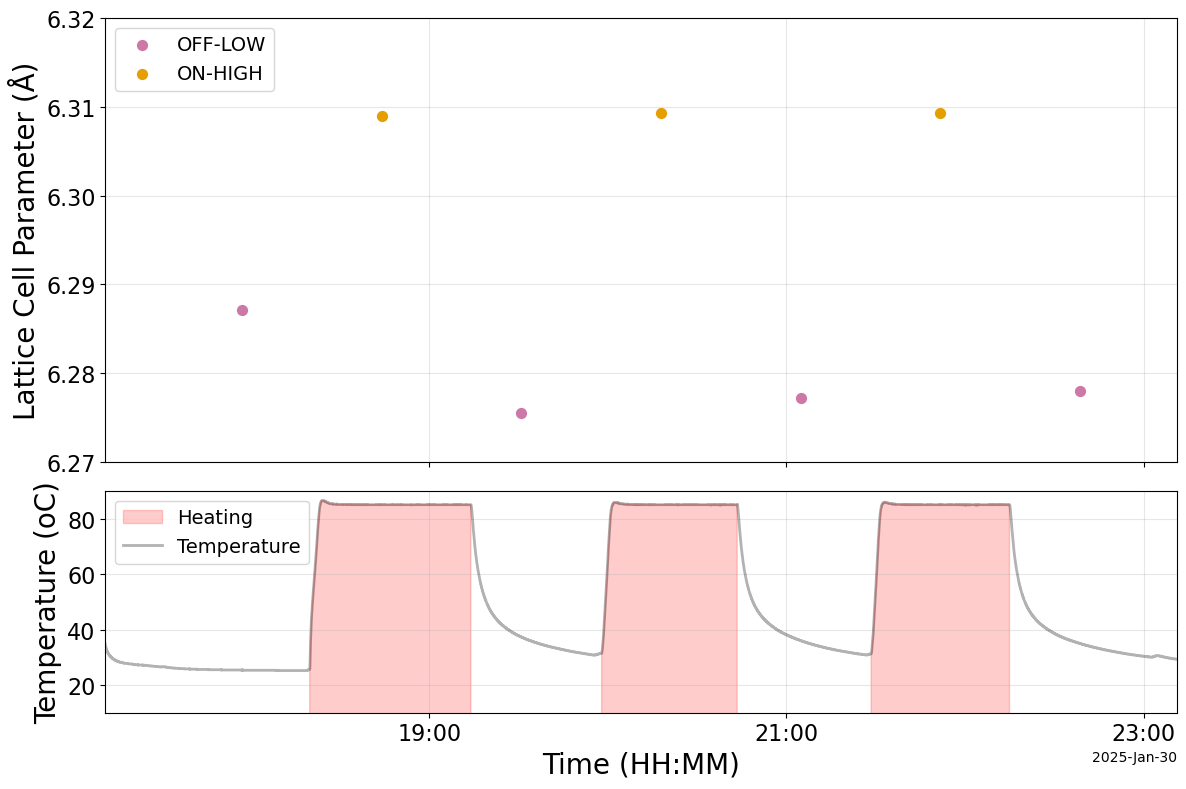

In [307]:
# Create figure with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, height_ratios=[2, 1])

# Top plot: Nelson-Riley intercepts
colors = {'ON-HIGH': '#E69F00', 'ON-LOW': '#56B4E9', 'OFF-HIGH': '#009E73', 'OFF-LOW': '#CC79A7'}

for state, group in nr.groupby(['light_state', 'Heat_state']):
    label = f"{state[0]}-{state[1]}"
    ax1.scatter(group['Time'], group['intercept'], c=colors[label], label=label, s=50)

# Bottom plot: Temperature and Light conditions
heat_mask = temp_df['Heat_state'] == 'HIGH'
ax2.fill_between(temp_df['Time'], temp_df['Temperature']-10, where = heat_mask,
            color='red', alpha =0.2, label='Heating')
ax2.plot(temp_df['Time'], temp_df['Temperature']-10, 'k-', alpha=0.3, lw=2, label = 'Temperature')

# Format axes
ax1.set_ylabel('Lattice Cell Parameter (Å)', fontsize=20)
ax1.legend(loc='upper left', fontsize=14, frameon=True)
ax1.set_ylim(6.27, 6.32)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2.set_ylabel('Temperature (oC)', fontsize=20)
ax2.set_xlabel('Time (HH:MM)', fontsize=20)
ax2.set_ylim(10, 90)
ax2.legend(loc='upper left', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=16)

locator = mdates.AutoDateLocator()  # Automatically adjust ticks based on the data range
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_formatter(formatter)

ax1.set_xlim(start_time, start_time + pd.Timedelta(hours=6))
ax2.set_xlim(start_time, start_time + pd.Timedelta(hours=6))

plt.tight_layout()


In [308]:
def read_iV(file, start_time, end_time):
    print(file)
    iv_data = pd.read_csv(file, delimiter='\t', header=None, encoding='latin1')
    # Extract timestamp from middle of file
    date_part = start_time.strftime('%Y-%m-%d')
    time_hms = iv_data[0].iloc[len(iv_data)//2]
    print(f"time value: {time_hms}")
    if int(str(time_hms).split(':')[0]) > 23:
        # Add one day to date_part
        date_part = (pd.to_datetime(date_part) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        print(date_part)
        # Adjust hour value
        hours = int(str(time_hms).split(':')[0]) - 24
        time_hms = f"{hours:02d}:{':'.join(str(time_hms).split(':')[1:])}"

    mid_time = pd.to_datetime(f'{date_part} {time_hms}', format='%Y-%m-%d %H:%M:%S')
    print(mid_time.hour)
    plt.plot(iv_data[1], iv_data[2])
    if start_time <= mid_time <= end_time:
        return mid_time, iv_data[1], iv_data[2]
    else: 
        return None, None, None

     Sample      Temp                Time  intercept  Seconds  measured_temp  \
0  7P1onOFF  ecovery. 2025-01-31 10:02:14   6.278685  60667.0           33.3   
0  7P1onOFF  dark_RT. 2025-01-30 17:57:03   6.287068   2756.0           35.4   
0  7P1onOFF  SM_L_85. 2025-01-30 18:43:59   6.308909   5572.0           95.1   
0  7P1onOFF  dark_RT. 2025-01-30 19:30:54   6.275476   8387.0           47.3   
0  7P1onOFF  SM_L_85. 2025-01-30 20:17:50   6.309293  11203.0           95.0   
0  7P1onOFF  dark_RT. 2025-01-30 21:04:46   6.277172  14019.0           46.0   
0  7P1onOFF  SM_L_85. 2025-01-30 21:51:42   6.309275  16835.0           95.0   
0  7P1onOFF  dark_RT. 2025-01-30 22:38:38   6.277955  19651.0           44.9   

  Heat_state light_state  
0        LOW         OFF  
0        LOW         OFF  
0       HIGH          ON  
0        LOW         OFF  
0       HIGH          ON  
0        LOW         OFF  
0       HIGH          ON  
0        LOW         OFF  
\\?\C:\Users\fbaumann\PyProjects_AMZ

C:\Users\fbaumann\AppData\Local\Temp\ipykernel_18996\1280550720.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iv_matches = pd.concat([iv_matches, pd.DataFrame({


time value: 19:54:28
19
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\dark5.1.txt
time value: 20:44:11
20
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\dark5.2.txt
time value: 21:25:52
21
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\dark7.1.txt
time value: 22:16:33
22
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\dark7.2.txt
time value: 23:02:00
23
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\darkfinal7.3.txt
time value: 23:05:19
23
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\light2.1.txt
time value: 18:19:16
18
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\light2.2.txt
time value: 18:26:22
18
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\light2.3.txt
time value: 19:13:13
19
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\light4.1.txt
time value: 19:58:41
19
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\REF\DP7P1\light4.2.txt
time value: 20:03:49

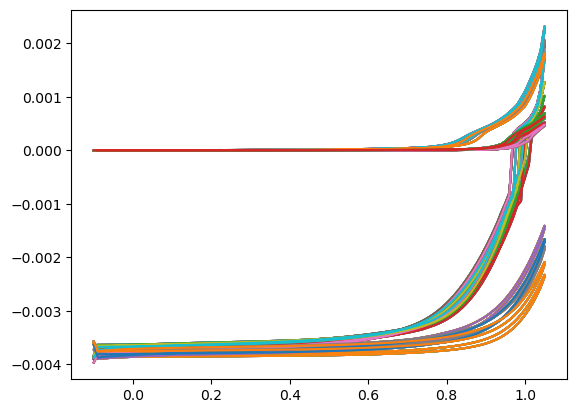

In [309]:
print(nr)
light_iv_assets = list(filter(lambda asset: 'light' in asset.file.lower() and 'txt' in asset.file.lower() and not str(asset.file).endswith("light.txt") and not str(asset.file).endswith('d.txt')and not str(asset.file).endswith('20.txt'), main_assets))
dark_iv_assets = list(filter(lambda asset: 'dark' in asset.file.lower() and 'txt' in asset.file.lower() and not 'Dome' in str(asset.file) and not str(asset.file).endswith('d.txt'), main_assets))

iv_matches = pd.DataFrame(columns=['NR_time', 'state', 'jv_time', 'type', 'voltage', 'current'])

for time in nr['Time'].unique():
    row = nr[nr['Time'] == time]
    time_window = pd.Timedelta(minutes=25)  # Adjust window as needed
    date_part = row['Time'].iloc[0].strftime('%Y-%m-%d')
    time_hms = row['Time'].iloc[0].strftime('%H:%M:%S')
    time_full = f"{date_part} {time_hms}"
    start_time = pd.to_datetime(time_full) - time_window
    end_time = pd.to_datetime(time_full) + time_window
    state = str(f"{row['light_state'].iloc[0]}-{row['Heat_state'].iloc[0]}")
    
    # Check light JV files
    for asset in light_iv_assets:
        t, volt, curr = read_iV(asset.file, start_time, end_time)
        if t:
            iv_matches = pd.concat([iv_matches, pd.DataFrame({
                'NR_time': row['Time'].iloc[0],
                'state': state,
                'jv_time': t,
                'type': 'light',
                'voltage': volt,
                'current': curr
            })])
    
    # Check dark JV files
    for asset in dark_iv_assets:
        t, volt, curr = read_iV(asset.file, start_time, end_time)
        if t:
            iv_matches = pd.concat([iv_matches, pd.DataFrame({
                'NR_time': row['Time'].iloc[0],
                'state': state,
                'jv_time': t,
                'type': 'dark',
                'voltage': volt,
                'current': curr
            })])

print(iv_matches)

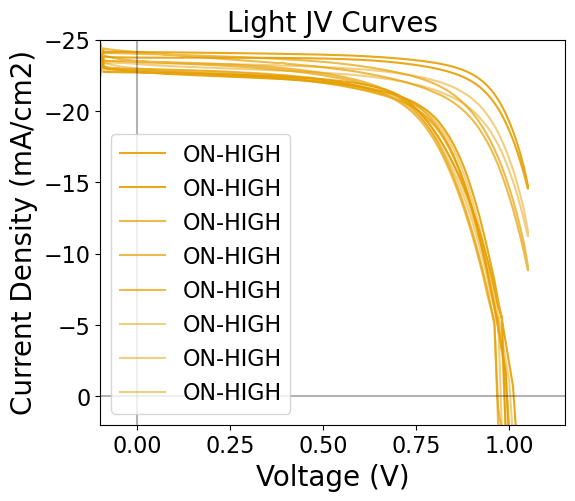

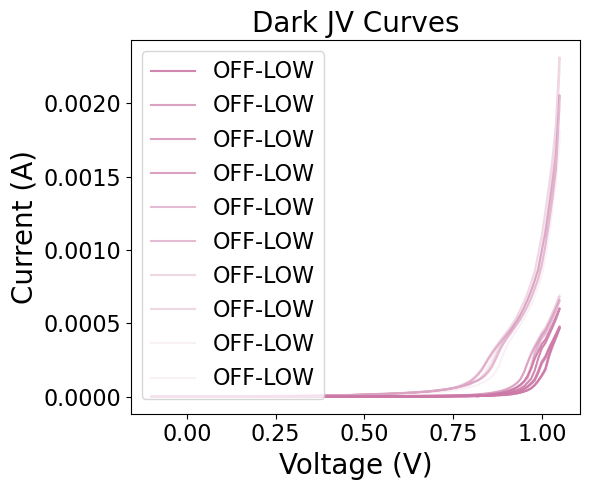

In [310]:
# Define color scheme for states
colors = {'ON-HIGH': '#E69F00', 'ON-LOW': '#56B4E9', 'OFF-HIGH': '#009E73', 'OFF-LOW': '#CC79A7'}

# Light JV figure
fig_light, ax_light = plt.subplots(figsize=(6, 5))
light_data = iv_matches[iv_matches['type']=='light']
for state in light_data['state'].unique():
    state_data = iv_matches[iv_matches['state']==state]
    alp = 0.9
    for case in state_data['NR_time'].unique():
        rows = state_data[state_data['NR_time']==case]
        i = 0
        for time in rows['jv_time'].unique():
            row = rows[rows['jv_time']==time]
            stL1 = ['ON' if 'ON' in row['state'].iloc[0] else 'OFF']
            stL2 = ['ON' if row['type'].iloc[0] =='light' else 'OFF']
            if stL1[0]!=stL2[0]:
                i += 1
                continue
            if stL1[0]!='ON':
                i += 1
                continue
            else:
                ax_light.plot(row['voltage'], row['current']/0.00016, color=colors[state], alpha = alp, label=state)
        alp += -0.2
ax_light.set_xlabel('Voltage (V)', fontsize=20)
ax_light.set_ylabel('Current Density (mA/cm2)', fontsize=20)
ax_light.tick_params(axis='both', which='major', labelsize=16)
ax_light.legend(loc = 'lower left', fontsize=16)
ax_light.set_title('Light JV Curves', fontsize=20)
ax_light.set_xlim([-0.1,1.15])
ax_light.set_ylim([2,-25]) 
# Add to light JV plot
ax_light.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax_light.axvline(x=0, color='k', linestyle='-', alpha=0.3)


# Dark JV figure
fig_dark, ax_dark = plt.subplots(figsize=(6, 5))
dark_data = iv_matches[iv_matches['type']=='dark']
for state in dark_data['state'].unique():
    alp = 0.9
    state_data = dark_data[dark_data['state']==state]
    for case in state_data['NR_time'].unique():
        rows = state_data[state_data['NR_time']==case]
        i = 0
        for time in rows['jv_time'].unique():
            row = rows[rows['jv_time']==time]
            stL1 = ['ON' if 'ON' in row['state'].iloc[0] else 'OFF']
            stL2 = ['ON' if row['type'].iloc[0] =='light' else 'OFF']
            if stL1[0]!=stL2[0]:
                i += 1
                continue
            if stL1[0]!='OFF':
                i += 1
                continue
            else:
                ax_dark.plot(row['voltage'], row['current'], color=colors[state], alpha = alp, label=state)
        alp += -0.2
ax_dark.set_xlabel('Voltage (V)', fontsize=20)
ax_dark.set_ylabel('Current (A)', fontsize=20)
ax_dark.tick_params(axis='both', which='major', labelsize=16)
ax_dark.legend(fontsize=16)
ax_dark.set_title('Dark JV Curves', fontsize=20)

plt.tight_layout()

In [98]:


xrd_assets = list(filter(lambda asset: asset.file.endswith("xrdml"), assets))
'''xrd1 = list(filter(lambda asset: "01" in asset.file, xrd_assets))[0]
xrd2 = list(filter(lambda asset: "02" in asset.file, xrd_assets))[0]
xrd15 = list(filter(lambda asset: "15" in asset.file, xrd_assets))[0]
xrd40 = list(filter(lambda asset: "40" in asset.file, xrd_assets))[0]
xrd50 = list(filter(lambda asset: "50" in asset.file, xrd_assets))[0]
xrd62 = list(filter(lambda asset: "62" in asset.file, xrd_assets))[0]
xrd63 = list(filter(lambda asset: "63" in asset.file, xrd_assets))[0]
xrd65 = list(filter(lambda asset: "65" in asset.file, xrd_assets))[0]'''

xrd1 = list(filter(lambda asset: "01" in asset.file, xrd_assets))[0]
xrd6 = list(filter(lambda asset: "06" in asset.file, xrd_assets))[0]
xrd11 = list(filter(lambda asset: "11" in asset.file, xrd_assets))[0]
xrd16 = list(filter(lambda asset: "16" in asset.file, xrd_assets))[0]
xrd22 = list(filter(lambda asset: "22" in asset.file, xrd_assets))[0]
xrd27 = list(filter(lambda asset: "27" in asset.file, xrd_assets))[0]
xrd32 = list(filter(lambda asset: "32" in asset.file, xrd_assets))[0]
xrd37 = list(filter(lambda asset: "37" in asset.file, xrd_assets))[0]
xrd42 = list(filter(lambda asset: "42" in asset.file, xrd_assets))[0]
xrd57 = list(filter(lambda asset: "57" in asset.file, xrd_assets))[0]
xrd58 = list(filter(lambda asset: "58" in asset.file, xrd_assets))[0]
xrd59 = list(filter(lambda asset: "59" in asset.file, xrd_assets))[0]

'''xrd1 = list(filter(lambda asset: "01" in asset.file, xrd_assets))[0]
xrd10 = list(filter(lambda asset: "10" in asset.file, xrd_assets))[0]
xrd18 = list(filter(lambda asset: "18" in asset.file, xrd_assets))[0]
xrd27 = list(filter(lambda asset: "27" in asset.file, xrd_assets))[0]
xrd35 = list(filter(lambda asset: "35" in asset.file, xrd_assets))[0]
xrd44 = list(filter(lambda asset: "44" in asset.file, xrd_assets))[0]
xrd53 = list(filter(lambda asset: "53" in asset.file, xrd_assets))[0]
xrd62 = list(filter(lambda asset: "62" in asset.file, xrd_assets))[0]
xrd64 = list(filter(lambda asset: "64" in asset.file, xrd_assets))[0]
xrd65 = list(filter(lambda asset: "65" in asset.file, xrd_assets))[0]'''

#arr_list = [xrd1, xrd2, xrd15, xrd40, xrd50, xrd62, xrd63, xrd65]
#cond_list = [['dark','RT'],['1 sun', 'RT'], ['1 sun', 85], ['dark', 85], ['dark',85], ['1 sun',85], ['1 sun', 'RT'], ['dark','RT']]
#range_list = [[11,44],[19.3, 32], [19.3, 32], [19.3, 32], [19.3, 32], [11, 44], [19.3, 32], [11, 44]]
arr_list = [xrd1, xrd6, xrd11,xrd16,xrd22,xrd27,xrd32,xrd37, xrd42, xrd57, xrd58, xrd59]
cond_list = [['dark','RT'],['1 sun', 70], ['1 sun', 85], ['1 sun', 85],['1 sun', 85],['1 sun', 85],['1 sun', 85],['1 sun', 85],['1 sun', 85], ['dark',85], ['1 sun','cooling'], ['dark', 'cooling']]
range_list = [[10,44],[10,44], [10,44], [10,44],[10,44],[10,44],[10,44],[10,44],[10,44], [10,44], [10,44], [10,44]]
#arr_list = [xrd1, xrd10, xrd18,xrd27,xrd35,xrd44,xrd53,xrd62, xrd64, xrd65]
#cond_list = [['dark','RT'],['1 sun', 75], ['1 sun', 85], ['1 sun', 85],['1 sun', 85],['dark', 85],['dark', 85],['1 sun', 85],['1 sun', 'cooling'], ['dark','cooling']]
#range_list = [[10,44],[10,44], [10,44], [10,44],[10,44],[10,44],[10,44],[10,44],[10,44], [10,44]]

d_values = []
a_values = []
df_input = pd.DataFrame()
index = 0
for ass in arr_list: 
    new_frame = XRDframe(ass, light=cond_list[index][0], temp=cond_list[index][1])
    new_frame['range_low'] = range_list[index][0]
    new_frame['range_high'] = range_list[index][1]
    #new_row = pd.DataFrame(new_frame, index=[index])
    df_input = pd.concat([df_input, new_frame], ignore_index=False)
    index+=1  

        
ref_ftoAvalue = df_input['a_value_fto110'].mean()   #The average a value of the FTO110 peak is the reference
print('The reference for relative translation is a_value ', ref_ftoAvalue, ' Angstrom')

rel_a = []
a_corr = []
i = 0
while i < df_input.index.size:
    a = df_input['a_value_fto110'].iloc[i]
    a_rel = a/ref_ftoAvalue
    rel_a.append(a_rel)
    corr_a = a / a_rel
    a_corr.append(corr_a)
    i+=1
df_input.insert(3, 'rel_a', rel_a)
df_input.insert(4, 'corr_a', a_corr)
pd.set_option('display.max_columns',100)
print(df_input)

The reference for relative translation is a_value  4.794738046975625  Angstrom
                                                File  \
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   

                 start_time                  end_time     rel_a    corr_a  \
0 2024-11-28 09:45:28+01:00 2024-11-28 10:26:38+01:00  1.012858  4.794738   
0 2025-01-28 19:33:10+01:00 2025-01-28

['delta', 'i2Pb', 'p(001)', 'p(011)', 'unknown', 'p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004'] [[11.5, 11.8], [12, 12, 9], [13, 15], [19, 20], [21, 23], [24, 25], [26, 27], [27.7, 29], [30, 31], [31, 32], [33, 34], [34, 36], [37, 37.8], [37.8, 39], [39, 40], [40, 41], [42, 43], [43, 45], [48, 50.5], [50.5, 52], [52, 55], [55, 60]] 11 43 19 4.803231432910652
                  start_time light     temp      Peak        pos    amplitude  \
0  2024-11-27 12:48:37+01:00  dark       RT   Unknown  12.367516   575.124453   
1  2024-11-27 12:48:37+01:00  dark       RT    p(001)  13.702410   693.406376   
2  2024-11-27 12:48:37+01:00  dark       RT    p(011)  19.687081   769.406062   
3  2024-11-27 12:48:37+01:00  dark       RT    p(111)  24.228698   383.556848   
4  2024-11-27 12:48:37+01:00  dark       RT  FTO(110)  26.241031  1179.745760   
..                       ...   ...      ...       ...     

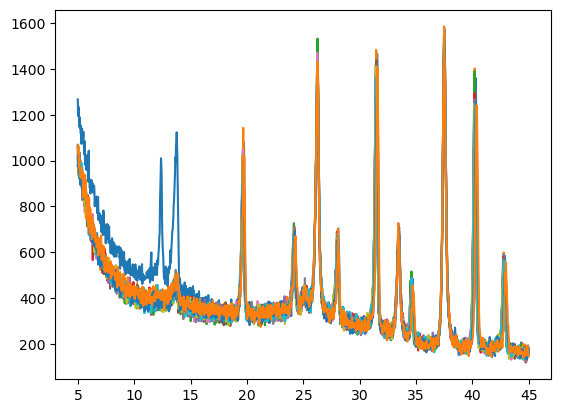

In [ ]:
#Defining the parameters of the experiment: Variation and what peaks are expected in what range of the scans.
variations = ['Ref','Mod']
max_num_peaks_per_sample = 19
peak_names = ['delta', 'i2Pb','p(001)', 'p(011)', 'unknown','p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004']
peak_ranges = [[11.5,11.8],[12,12,9], [13,15], [19,20], [21,23], [24,25], [26,27],[27.7,29],[30,31],[31,32],[33,34],[34,36],[37,37.8], [37.8,39], [39,40], [40,41],[42,43], [43,45], [48,50.5], [50.5,52], [52,55],[55,60]]

df_list = [df_input]
df_ranges = [[11, 43]]
maxpeaks = [19]

#Creating a dataframe and fitting the data
result_df = pd.DataFrame()   #columns=['Sample', 'Variation', 'Peak', 'pos', 'amplitude', 'stdvG', 'd_value','a_rel', 'rel_a']
i = 0 
ythres=200
while i < len(df_list):
    print(peak_names, peak_ranges, df_ranges[i][0], df_ranges[i][1], maxpeaks[i], ref_ftoAvalue)
    new_result_df = framefit(df_list[i], peak_names, peak_ranges, maxpeaks[i], ref_ftoAvalue, ythres, pl=False)
    result_df = pd.concat([result_df, new_result_df])
    i+=1
print(result_df)

In [136]:
#Calculating and adjusting a-values

a_values_raw = []
a_aligned = []
i = 0
while i < result_df.index.size: 
    d = result_df['d_value'].iloc[i]
    peak = result_df['Peak'].iloc[i]
    rel_a  = result_df['rel_a'].iloc[i]  #the correction in the intial calculation
    #a_rel  = result_df['a_rel'].iloc[i]
    if peak == 'FTO(110)':
        a = a_value(d,1,1,0)
        if a/ref_ftoAvalue != rel_a: #Checking that the correction (extracted again) is the same as in the intial calculation
            print('division error')
        a_corr = a/rel_a
    elif peak.startswith('p('):
        h = float(peak[2])
        k =  float(peak[3])
        l = float(peak[4])
        a = a_value(d, h , k, l)
        a_corr = a/rel_a   #Correcting a with the relative lateral alignment
    else: 
        a = 'NA'
        a_corr = 'NA'
    a_values_raw.append(a)
    a_aligned.append(a_corr)
    i+=1
        
result_df['a_raw'] = a_values_raw
result_df['a_final'] = a_aligned
print(result_df)

                  start_time light     temp      Peak        pos    amplitude  \
0  2024-11-27 12:48:37+01:00  dark       RT   Unknown  12.367516   575.124453   
1  2024-11-27 12:48:37+01:00  dark       RT    p(001)  13.702410   693.406376   
2  2024-11-27 12:48:37+01:00  dark       RT    p(011)  19.687081   769.406062   
3  2024-11-27 12:48:37+01:00  dark       RT    p(111)  24.228698   383.556848   
4  2024-11-27 12:48:37+01:00  dark       RT  FTO(110)  26.241031  1179.745760   
..                       ...   ...      ...       ...        ...          ...   
5  2024-11-28 08:34:04+01:00  dark  cooling     (211)  33.441118   475.652790   
6  2024-11-28 08:34:04+01:00  dark  cooling    defect  34.723347   237.791500   
7  2024-11-28 08:34:04+01:00  dark  cooling      FTO3  37.492753  1331.598613   
8  2024-11-28 08:34:04+01:00  dark  cooling    p(022)  40.363099  1077.727375   
9  2024-11-28 08:34:04+01:00  dark  cooling    p(003)  42.953256   376.281563   

       stdvG   d_value     

Text(0, 0.5, 'Intensity (counts)')

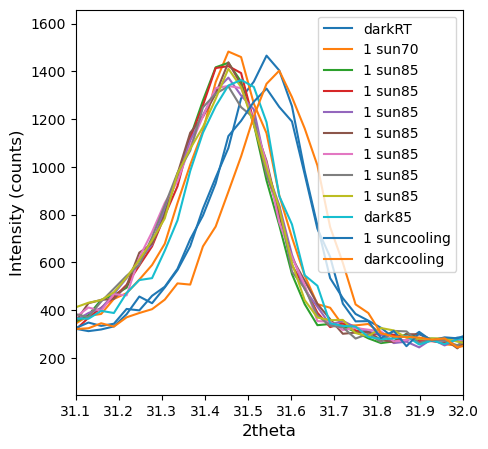

In [137]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
for start in df_input['start_time'].unique():
    data = df_input[df_input['start_time']==start]
    ax.plot(data['x_array'].iloc[0], data['y_array'].iloc[0], label=data['light'].iloc[0]+str(data['temperature'].iloc[0]))



ax.set_xlim([31.1,32])
ax.legend()
ax.set_xlabel('2theta', fontsize = 12)
ax.set_ylabel('Intensity (counts)', fontsize = 12)

1     13.702410
2     19.687081
3     24.228698
5     28.077044
6     31.529145
10    40.297467
11    42.869633
Name: pos, dtype: float64
dark RT [6.270923685952478] 6.270923685952478
0    19.647739
1    24.180061
3    28.020741
4    31.459400
8    40.204827
9    42.768445
Name: pos, dtype: float64
1 sun 70 [6.3093137768378105] 6.3093137768378105
0    19.624348
1    24.151623
3    27.991187
4    31.436099
8    40.177131
9    42.746997
Name: pos, dtype: float64
1 sun 85 [6.309750737609324] 6.309750737609324
0    19.623406
1    24.152593
3    28.000586
4    31.441112
8    40.188166
9    42.755913
Name: pos, dtype: float64
1 sun 85 [6.306827700243835] 6.306827700243835
0    19.625924
1    24.164526
3    27.993007
4    31.440101
8    40.188867
9    42.765019
Name: pos, dtype: float64
1 sun 85 [6.307208297712015] 6.307208297712015
0    19.623152
1    24.146908
3    27.988331
4    31.440271
8    40.188933
9    42.758468
Name: pos, dtype: float64
1 sun 85 [6.30639277838622] 6.30639277838622
0

<>:17: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20832\2958622560.py:17: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


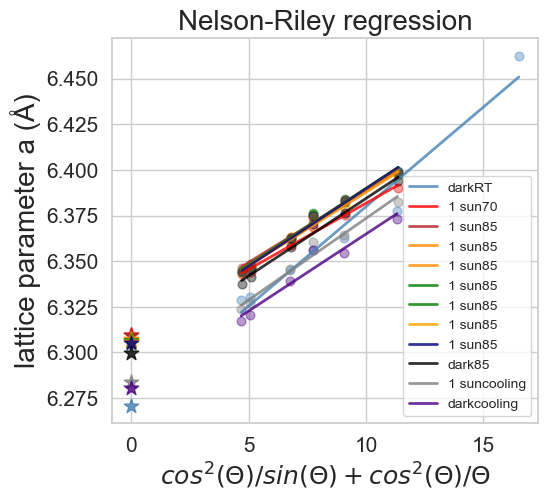

In [143]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red','firebrick', 'darkorange', 'darkorange','green','green','orange','navy', 'black','grey', 'indigo']
col_ind = 0
nr = pd.DataFrame()
for time in result_df['start_time'].unique():   
    data = result_df[result_df['start_time']==time]
    c = nelson_riley(data, ax, col_array[col_ind], 'a_raw', 'pos', alp=0.8, lab=data['light'].iloc[0]+str(data['temp'].iloc[0]))
    col_ind+=1
    #nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    #nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.25,6.32)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='lower right', fontsize=10)  
#print(nr)

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20832\3788181526.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20832\3788181526.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


KeyError: 'Sample'

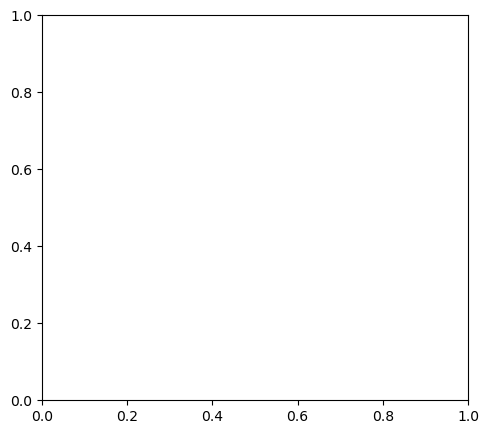

In [95]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black','green','orange','grey']
col_ind = 0
nr = pd.DataFrame()
for samp in result_df['Sample'].unique():   #)
    sample = result_df[result_df['Sample']==samp]
    if sample['Variation'].iloc[0]=='Mod':
        c = nelson_riley(sample,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.8, lab=samp)
    if sample['Variation'].iloc[0]=='Ref':
        c = nelson_riley(sample,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.2, lab=samp)
    col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
ax.set_ylim(6.26,6.29)
ax.set_xlim(-0.5,1)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper right', fontsize=12)  
print(nr)
fig2, ax2 = plt.subplots(figsize=(3,7))
nr.boxplot(column='intercept', by='Variation', ax=ax2, boxprops=dict(color='blue'))

In [308]:
condi_ON = list(filter(lambda asset: asset.file.endswith('On.xrdml'), xrd_assets))
df_ON = pd.DataFrame()
index = 0
for ass in condi_ON:
    file = ass.file
    var = ass.metadata['var']
    samp = ass.metadata['name']
    two_theta, y, start_time, end_time = readXRDML(file)
    start = pd.to_datetime(start_time)
    end = pd.to_datetime(end_time)
    center, amplitude, stddev, peak_count = fit_XRD(two_theta, y, low_Xthres=25.8, high_Xthres=27.5, maxpeaks=5, y_thres=400, Fitplot=False)
    d = braggs(center[0])
    d_values.append(d)
    a = (a_value(d, 1, 1, 0))
    a_values.append(a)
    new_input = {
        'File':file,
        'FTO110_pos': center[0], 
        'Sample': samp,
        'Variation': var,
        'light':'dark',
        'temperature':'RT', 
        'd_value_fto110': d,
        'a_value_fto110':a, 
        'x_array': two_theta, 
        'y_array':y,
        'rel_a':1
    }
    index+=1
    new_row = pd.DataFrame([new_input], index=[index])
    df_ON = pd.concat([df_ON, new_row], ignore_index=True)
print(df_ON['x_array'].values)

[array([10.01477157, 10.04431471, 10.07385784, ..., 44.93475842,
        44.96430155, 44.99384469])
 array([10.01477157, 10.04431471, 10.07385784, ..., 44.93475842,
        44.96430155, 44.99384469])
 array([10.01477157, 10.04431471, 10.07385784, ..., 44.93475842,
        44.96430155, 44.99384469])                              ]


In [309]:
#Defining the parameters of the experiment: Variation and what peaks are expected in what range of the scans.
variations = ['Ref','Mod']
max_num_peaks_per_sample = 19
peak_names = ['delta', 'i2Pb','p(001)', 'p(011)', 'unknown','p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004']
peak_ranges = [[11.5,11.8],[12,12,9], [13,15], [19,20], [21,23], [24,25], [26,27],[28,29],[30,31],[31,32],[33,34],[34,36],[37,37.8], [37.8,39], [39,40], [40,41],[42,43], [43,45], [48,50.5], [50.5,52], [52,55],[55,60]]

df_list = [df_ON]
df_ranges = [[10.5, 44]]
maxpeaks = [19]

#Creating a dataframe and fitting the data
result_ON = pd.DataFrame()   #columns=['Sample', 'Variation', 'Peak', 'pos', 'amplitude', 'stdvG', 'd_value','a_rel', 'rel_a']
i = 0 
ythres=200
while i < len(df_list):
    new_result_df = framefit(df_list[i], peak_names, peak_ranges, df_ranges[i][0], df_ranges[i][1], maxpeaks[i], ref_ftoAvalue, ythres, pl=False)
    result_ON = pd.concat([result_ON, new_result_df])
    i+=1
print(result_ON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP14       Mod    p(001)  13.349445   208.184027  1.017018  6.632711   
1    DP14       Mod    p(001)  13.916942   215.905857  0.834897  6.363497   
2    DP14       Mod    p(001)  14.529940   205.113935  1.017420  6.096380   
3    DP14       Mod   Unknown  15.097016   208.272304  0.695422  5.868640   
4    DP14       Mod   Unknown  16.076815   172.573794  1.083027  5.513116   
5    DP14       Mod   Unknown  25.949068   699.564352  0.240583  3.433743   
6    DP14       Mod   Unknown  27.711799   289.512566  0.363648  3.219202   
7    DP14       Mod    p(012)  31.157245  1050.361518  0.238665  2.870628   
8    DP14       Mod     (211)  33.181318   453.732145  0.221945  2.700001   
9    DP14       Mod    defect  34.291469   251.402199  0.161765  2.615091   
10   DP14       Mod      FTO3  37.728165  4874.007347  0.309719  2.384408   
11   DP14       Mod       Au2  39.911322  1076.643715  0.197228  2.258872   

In [311]:
#Calculating and adjusting a-values

a_values_raw = []
a_aligned = []
i = 0
while i < result_ON.index.size: 
    d = result_ON['d_value'].iloc[i]
    peak = result_ON['Peak'].iloc[i]
    rel_a  = result_ON['rel_a'].iloc[i]  #the correction in the intial calculation
    #a_rel  = result_df['a_rel'].iloc[i]
    if peak == 'FTO(110)':
        a = a_value(d,1,1,0)
        if a/ref_ftoAvalue != rel_a: #Checking that the correction (extracted again) is the same as in the intial calculation
            print('division error')
        a_corr = a/rel_a
    elif peak.startswith('p('):
        h = float(peak[2])
        k =  float(peak[3])
        l = float(peak[4])
        a = a_value(d, h , k, l)
        a_corr = a/rel_a   #Correcting a with the relative lateral alignment
    else: 
        a = 'NA'
        a_corr = 'NA'
    a_values_raw.append(a)
    a_aligned.append(a_corr)
    i+=1
        
result_ON['a_raw'] = a_values_raw
result_ON['a_final'] = a_aligned
print(result_ON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP14       Mod    p(001)  13.349445   208.184027  1.017018  6.632711   
1    DP14       Mod    p(001)  13.916942   215.905857  0.834897  6.363497   
2    DP14       Mod    p(001)  14.529940   205.113935  1.017420  6.096380   
3    DP14       Mod   Unknown  15.097016   208.272304  0.695422  5.868640   
4    DP14       Mod   Unknown  16.076815   172.573794  1.083027  5.513116   
5    DP14       Mod   Unknown  25.949068   699.564352  0.240583  3.433743   
6    DP14       Mod   Unknown  27.711799   289.512566  0.363648  3.219202   
7    DP14       Mod    p(012)  31.157245  1050.361518  0.238665  2.870628   
8    DP14       Mod     (211)  33.181318   453.732145  0.221945  2.700001   
9    DP14       Mod    defect  34.291469   251.402199  0.161765  2.615091   
10   DP14       Mod      FTO3  37.728165  4874.007347  0.309719  2.384408   
11   DP14       Mod       Au2  39.911322  1076.643715  0.197228  2.258872   

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_6264\255164215.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


Mod [6.282895575021049] 6.282895575021049
Mod [6.303817317459682] 6.303817317459682
Ref [6.313308427273386] 6.313308427273386
  Sample Variation  intercept
0   DP14       Mod   6.282896
0   DP19       Mod   6.303817
0    DP6       Ref   6.313308


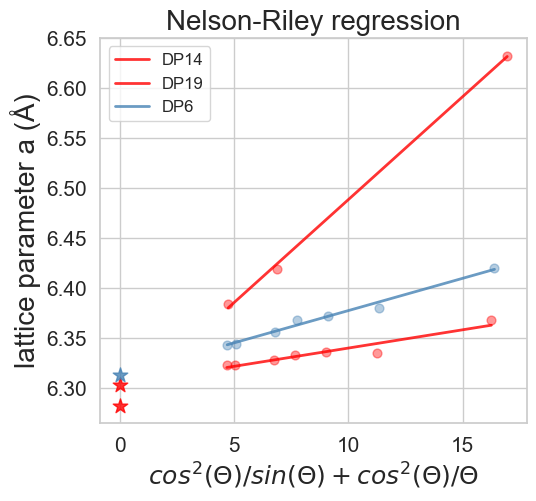

In [312]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black','green','orange','grey']
col_ind = 0
nrON = pd.DataFrame()
for samp in result_ON['Sample'].unique():   #)
    sample = result_ON[result_ON['Sample']==samp]
    if sample['Variation'].iloc[0]=='Mod':
        c = nelson_riley(sample,ax, col_array[1], 'a_raw', 'pos', alp=0.8, lab=samp)
    if sample['Variation'].iloc[0]=='Ref':
        c = nelson_riley(sample,ax, col_array[0], 'a_raw', 'pos', alp=0.8, lab=samp)
    #col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nrON = pd.concat([nrON, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper left', fontsize=12)  
print(nrON)

In [316]:
condi_longON = list(filter(lambda asset: '27' in asset.file, xrd_assets))
df_longON = pd.DataFrame()
index = 0
for ass in condi_longON:
    file = ass.file
    var = ass.metadata['var']
    samp = ass.metadata['name']
    two_theta, y, start_time, end_time = readXRDML(file)
    start = pd.to_datetime(start_time)
    end = pd.to_datetime(end_time)
    center, amplitude, stddev, peak_count = fit_XRD(two_theta, y, low_Xthres=25.8, high_Xthres=27.5, maxpeaks=5, y_thres=400, Fitplot=False)
    d = braggs(center[0])
    d_values.append(d)
    a = (a_value(d, 1, 1, 0))
    a_values.append(a)
    new_input = {
        'File':file,
        'FTO110_pos': center[0], 
        'Sample': samp,
        'Variation': var,
        'light':'dark',
        'temperature':'RT', 
        'd_value_fto110': d,
        'a_value_fto110':a, 
        'x_array': two_theta, 
        'y_array':y,
        'rel_a':1
    }
    index+=1
    new_row = pd.DataFrame([new_input], index=[index])
    df_longON = pd.concat([df_longON, new_row], ignore_index=True)
print(df_longON['x_array'].values)
print(df_longON['Sample'].unique())

[array([ 4.98377157,  5.01331471,  5.04285784, ..., 44.92609155,
        44.95563468, 44.98517782])
 array([19.01357157, 19.04311471, 19.07265784, 19.10220098, 19.13174411,
        19.16128725, 19.19083039, 19.22037352, 19.24991666, 19.27945979,
        19.30900293, 19.33854607, 19.3680892 , 19.39763234, 19.42717548,
        19.45671861, 19.48626175, 19.51580488, 19.54534802, 19.57489116,
        19.60443429, 19.63397743, 19.66352056, 19.6930637 , 19.72260684,
        19.75214997, 19.78169311, 19.81123624, 19.84077938, 19.87032252,
        19.89986565, 19.92940879, 19.95895192, 19.98849506, 20.0180382 ,
        20.04758133, 20.07712447, 20.1066676 , 20.13621074, 20.16575388,
        20.19529701, 20.22484015, 20.25438329, 20.28392642, 20.31346956,
        20.34301269, 20.37255583, 20.40209897, 20.4316421 , 20.46118524,
        20.49072837, 20.52027151, 20.54981465, 20.57935778, 20.60890092,
        20.63844405, 20.66798719, 20.69753033, 20.72707346, 20.7566166 ,
        20.78615973, 20.

In [317]:
#Defining the parameters of the experiment: Variation and what peaks are expected in what range of the scans.
variations = ['Ref','Mod']
max_num_peaks_per_sample = 19
peak_names = ['delta', 'i2Pb','p(001)', 'p(011)', 'unknown','p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004']
peak_ranges = [[11.5,11.8],[12,12,9], [13,15], [19,20], [21,23], [24,25], [26,27],[28,29],[30,31],[31,32],[33,34],[34,36],[37,37.8], [37.8,39], [39,40], [40,41],[42,43], [43,45], [48,50.5], [50.5,52], [52,55],[55,60]]

df_list = [df_longON[df_longON['Sample']!='DP8']]
df_ranges = [[6, 44]]
maxpeaks = [19]

#Creating a dataframe and fitting the data
result_longON = pd.DataFrame()   #columns=['Sample', 'Variation', 'Peak', 'pos', 'amplitude', 'stdvG', 'd_value','a_rel', 'rel_a']
i = 0 
ythres=200
while i < len(df_list):
    new_result_df = framefit(df_list[i], peak_names, peak_ranges, df_ranges[i][0], df_ranges[i][1], maxpeaks[i], ref_ftoAvalue, ythres, pl=False)
    result_longON = pd.concat([result_longON, new_result_df])
    i+=1
print(result_longON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP21       Mod    p(011)  19.623152   711.184896  0.254584  4.524050   
1    DP21       Mod    p(111)  24.146908   385.200976  0.509406  3.685775   
2    DP21       Mod  FTO(110)  26.240295  1113.526875  0.508082  3.396291   
3    DP21       Mod   Unknown  27.988331   374.706173  0.301928  3.188021   
4    DP21       Mod    p(012)  31.440271  1130.443283  0.236441  2.845429   
5    DP21       Mod     (211)  33.445498   478.773078  0.212296  2.679276   
6    DP21       Mod    defect  34.568332   255.947531  0.221766  2.594778   
7    DP21       Mod      FTO3  37.507573  1326.258442  0.309866  2.397923   
8    DP21       Mod    p(022)  40.188933  1087.203279  0.304473  2.243907   
9    DP21       Mod    p(003)  42.758468   423.490803  0.225146  2.114825   
0     DP1       Ref    p(001)  13.902206   446.876540  0.235965  6.370209   
1     DP1       Ref    p(011)  19.792018  1126.061294  0.212603  4.485831   

In [320]:
#Calculating and adjusting a-values

a_values_raw = []
a_aligned = []
i = 0
while i < result_longON.index.size: 
    d = result_longON['d_value'].iloc[i]
    peak = result_longON['Peak'].iloc[i]
    rel_a  = result_longON['rel_a'].iloc[i]  #the correction in the intial calculation
    #a_rel  = result_df['a_rel'].iloc[i]
    if peak == 'FTO(110)':
        a = a_value(d,1,1,0)
        if a/ref_ftoAvalue != rel_a: #Checking that the correction (extracted again) is the same as in the intial calculation
            print('division error')
        a_corr = a/rel_a
    elif peak.startswith('p('):
        h = float(peak[2])
        k =  float(peak[3])
        l = float(peak[4])
        a = a_value(d, h , k, l)
        a_corr = a/rel_a   #Correcting a with the relative lateral alignment
    else: 
        a = 'NA'
        a_corr = 'NA'
    a_values_raw.append(a)
    a_aligned.append(a_corr)
    i+=1
        
result_longON['a_raw'] = a_values_raw
result_longON['a_final'] = a_aligned
print(result_longON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP21       Mod    p(011)  19.623152   711.184896  0.254584  4.524050   
1    DP21       Mod    p(111)  24.146908   385.200976  0.509406  3.685775   
2    DP21       Mod  FTO(110)  26.240295  1113.526875  0.508082  3.396291   
3    DP21       Mod   Unknown  27.988331   374.706173  0.301928  3.188021   
4    DP21       Mod    p(012)  31.440271  1130.443283  0.236441  2.845429   
5    DP21       Mod     (211)  33.445498   478.773078  0.212296  2.679276   
6    DP21       Mod    defect  34.568332   255.947531  0.221766  2.594778   
7    DP21       Mod      FTO3  37.507573  1326.258442  0.309866  2.397923   
8    DP21       Mod    p(022)  40.188933  1087.203279  0.304473  2.243907   
9    DP21       Mod    p(003)  42.758468   423.490803  0.225146  2.114825   
0     DP1       Ref    p(001)  13.902206   446.876540  0.235965  6.370209   
1     DP1       Ref    p(011)  19.792018  1126.061294  0.212603  4.485831   

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_6264\3468635048.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


Mod [6.305776508011934] 6.305776508011934
Ref [6.31017032515707] 6.31017032515707
Ref [6.290893322898955] 6.290893322898955
  Sample Variation  intercept
0   DP21       Mod   6.305777
0    DP1       Ref   6.310170
0   DP12       Ref   6.290893


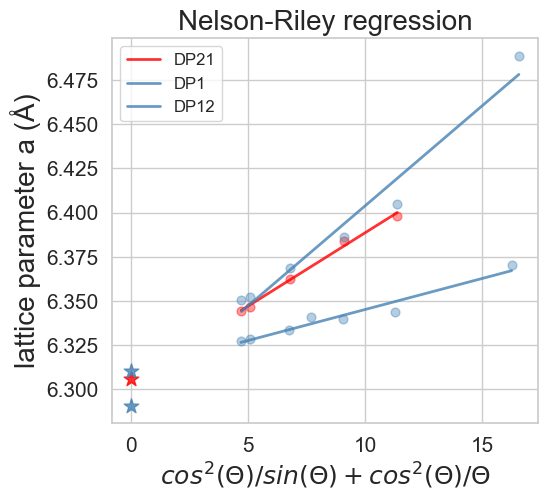

In [321]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black','green','orange','grey']
col_ind = 0
nrlongON = pd.DataFrame()
for samp in result_longON['Sample'].unique():   #)
    sample = result_longON[result_longON['Sample']==samp]
    if sample['Variation'].iloc[0]=='Mod':
        c = nelson_riley(sample,ax, col_array[1], 'a_raw', 'pos', alp=0.8, lab=samp)
    if sample['Variation'].iloc[0]=='Ref':
        c = nelson_riley(sample,ax, col_array[0], 'a_raw', 'pos', alp=0.8, lab=samp)
    #col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nrlongON = pd.concat([nrlongON, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper left', fontsize=12)  
print(nrlongON)

<>:23: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_6264\2499059124.py:23: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


Mod [6.305776508011934] 6.305776508011934
Mod [6.270923685862283] 6.270923685862283
Ref [6.31017032515707] 6.31017032515707
Ref [6.285698510850395] 6.285698510850395
Ref [6.290893322898955] 6.290893322898955
Ref [6.2632506915674515] 6.2632506915674515
  Sample Variation  intercept
0   DP21       Ref   6.270924
0    DP1       Ref   6.285699
0   DP12       Ref   6.263251


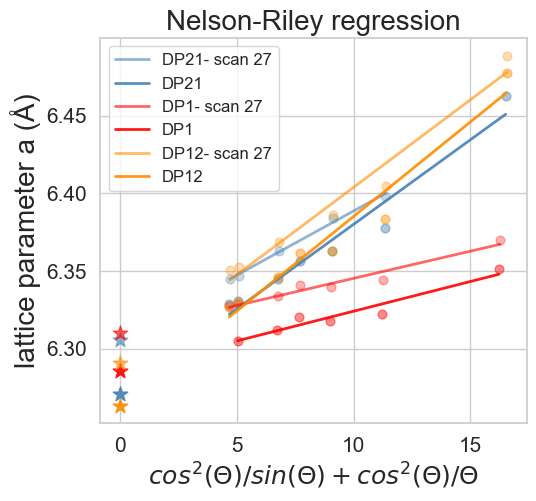

In [326]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'darkorange', 'black','green','orange','grey', 'navy']
col_ind = 0
nrlong = pd.DataFrame()
for samp in result_longON['Sample'].unique():   #)
    long = result_longON[result_longON['Sample']==samp]
    init = result_df[result_df['Sample']==samp]
    if long['Variation'].iloc[0]=='Mod':
        c = nelson_riley(long,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.6, lab=samp+'- scan 27')
        c = nelson_riley(init,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.9, lab=samp)
    if long['Variation'].iloc[0]=='Ref':
        c = nelson_riley(long,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.6, lab=samp+'- scan 27')
        c = nelson_riley(init,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.9, lab=samp)
    col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nrlong = pd.concat([nrlong, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper left', fontsize=12)  
print(nrlong)

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\1180724946.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


B4P5
Ref [6.31142428074104] 6.31142428074104
B4P18
Mod [6.30794504044467] 6.30794504044467
B4P3_scan10
Ref [6.340963213556863] 6.340963213556863
B4P11_scan10
Mod [6.334169675281775] 6.334169675281775


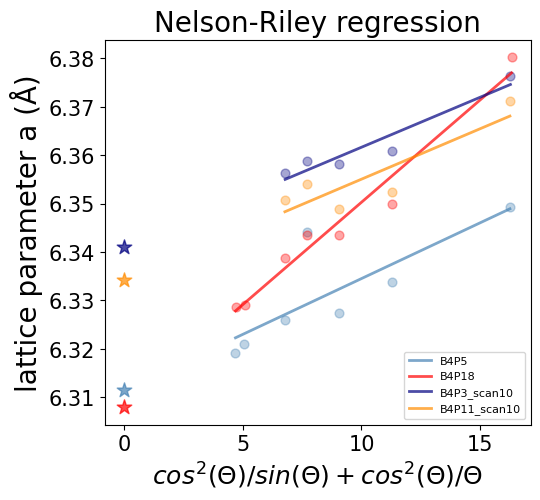

In [18]:
#Nelson-Riley figure with final (adjusted) a-values

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black', 'chocolate', 'grey', 'magenta', 'crimson']
col_ind = 0
nr = pd.DataFrame()
for samp in df_xshift[df_xshift['iniType'].str.startswith('complet')]['Sample'].unique():   #)
    if samp.startswith('B4'):
        print(samp)
        sample = result_df[result_df['Sample']==samp]
        label= samp
        c = nelson_riley(sample,ax, col_array[col_ind], 'a_final', 'pos', 0.7, label)
        col_ind+=1
        nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
        nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.295,6.310)
#ax.set_xlim(4.5,5.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='lower right', fontsize=8)   

In [19]:
#This small calculation was used to identify outlier datapoints, leading to the elimination of (222), (004) and (112) from the analysis due to highly deviating values, probably because of low intensity of the peaks. 
the2 = 42
theta = the2/2
transform = math.cos(math.radians(theta))**2 / math.sin(math.radians(theta)) + math.cos(math.radians(theta))**2/math.radians(theta)
print(transform)

4.8100325786496345


Ref [6.327578450016769] 6.327578450016769
Mod [6.318581517905133] 6.318581517905133


<>:19: SyntaxWarning: invalid escape sequence '\T'
<>:19: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2885866371.py:19: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=20)


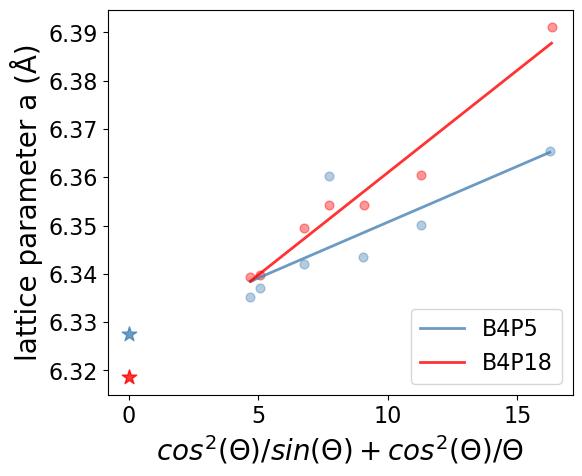

In [24]:
#Another plot variant with only the initial scans (RAW a value) of the batch used during time-resolved in-situ XRD

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'blue', 'purple']
col_ind = 0
nr = pd.DataFrame()
for samp in df_xshift[df_xshift['iniType'].str.startswith('complet')]['Sample'].unique():   #)
    if samp.startswith('B4'):
        if samp.endswith('scan10') == 0:
            sample = result_df[result_df['Sample']==samp]
            c = nelson_riley(sample,ax, col_array[col_ind], 'a_raw', 'pos', 0.8, samp)
            col_ind+=1
            nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
            nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=20)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title('Nelson-Riley regression', fontsize=28)
ax.legend(loc='lower right', fontsize=16)  

In [25]:
#Export of the fitted data and Nelson Riley fitting of the intercept (realistic a value)
result_df.to_excel('MergeAlignCheck.xlsx')
nr.to_excel('Nelson_Riley_check.xlsx')
print(result_df)
print(nr)

          Sample Variation      Peak        pos    amplitude     stdvG  \
0           B4P3       Ref    p(111)  24.304752  1059.305059  0.159459   
1           B4P3       Ref  FTO(110)  26.418181  1176.217201  0.246292   
2           B4P3       Ref    p(002)  28.132913  2454.436297  0.210443   
3           B4P3       Ref    p(012)  31.552430  1391.326877  0.184897   
0          B4P11       Mod    p(111)  24.329046   613.702914  0.187082   
..           ...       ...       ...        ...          ...       ...   
5   B4P11_scan10       Mod  FTO(110)  26.428932  1153.163252  0.228686   
6   B4P11_scan10       Mod    p(002)  28.113381  2391.971368  0.209420   
7   B4P11_scan10       Mod    p(012)  31.529714  1134.973875  0.230490   
8   B4P11_scan10       Mod     (211)  33.617107   550.568650  0.255875   
9   B4P11_scan10       Mod    defect  34.625895   162.412687  0.196491   

     d_value     rel_a     a_raw   a_final  
0   3.662195  0.999478  6.343107  6.346421  
1   3.373825  0.99947

Text(0, 0.5, '2theta angle Pseudo Voigt fitting, \n perovskite (012) peak')

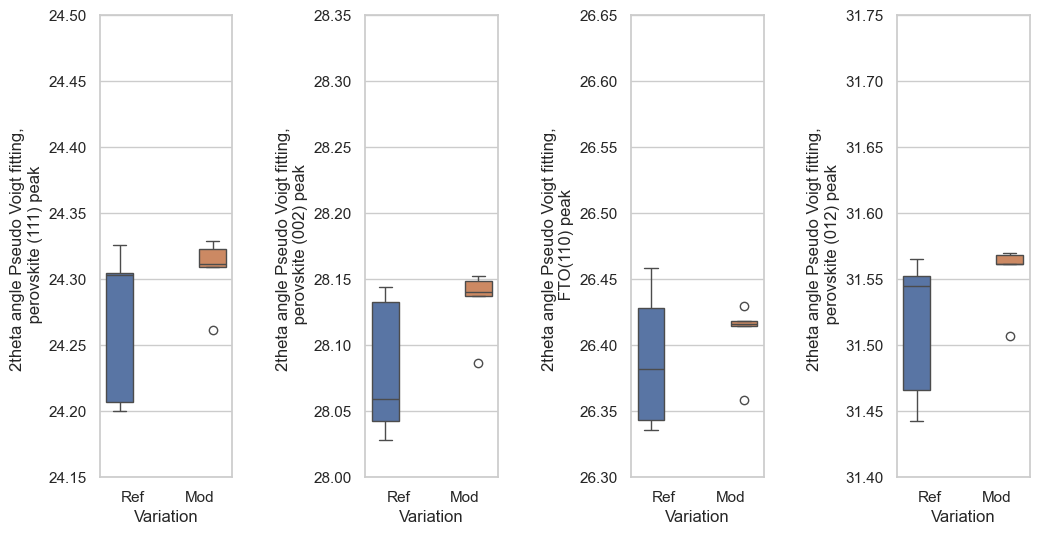

In [26]:
#A plot of the 2theta value

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
ax1, ax2, ax3, ax4 = axes.flatten()
i = 0

#B_df = result_df[result_df['Sample'].str.startswith('H')==0]
main_df = result_df[result_df['Sample'].str.startswith('F')==0]
ini_df = main_df[main_df['Sample'].str.endswith('scan10')==0]
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(111)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(002)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'FTO(110)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(012)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax4)


'''sns.boxplot(data=result_df[result_df['Peak'] == 'p(111)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(002)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=result_df[result_df['Peak'] == 'FTO(110)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(012)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax4)'''

ax1.set_ylim(24.15,24.50)
ax2.set_ylim(28.00,28.35)
ax3.set_ylim(26.30,26.65)
ax4.set_ylim(31.40,31.75)
ax1.set_ylabel('2theta angle Pseudo Voigt fitting, \n perovskite (111) peak')
ax2.set_ylabel('2theta angle Pseudo Voigt fitting, \n perovskite (002) peak')
ax3.set_ylabel('2theta angle Pseudo Voigt fitting, \n FTO(110) peak')
ax4.set_ylabel('2theta angle Pseudo Voigt fitting, \n perovskite (012) peak')


Text(0, 0.5, 'a value (Angstrom) \n p(012) peak')

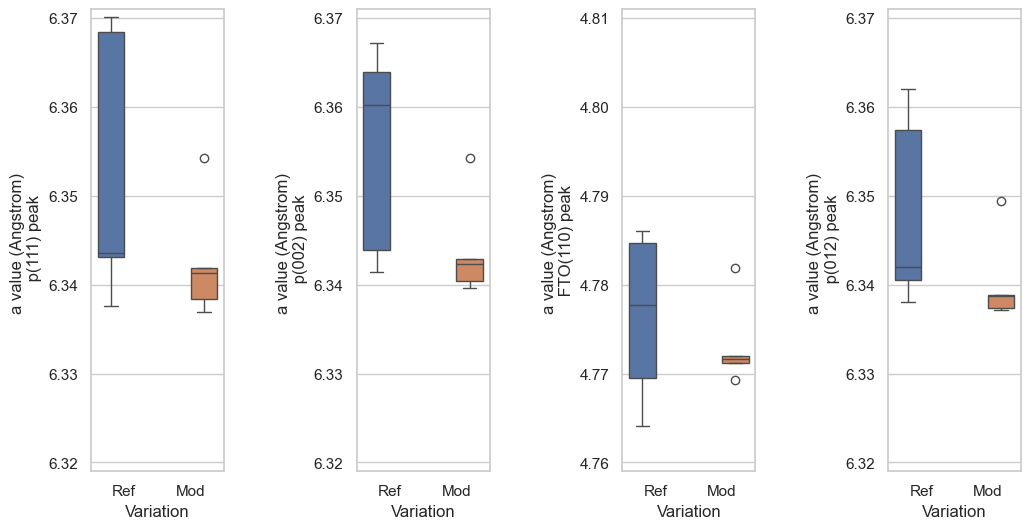

In [27]:
#A plot of the raw a-value value

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
ax1, ax2, ax3, ax4 = axes.flatten()
i = 0
'''sns.boxplot(data=result_df[result_df['Peak'] == 'p(111)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(002)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=result_df[result_df['Peak'] == 'FTO(110)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(012)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax4)'''

B_df = result_df[result_df['Sample'].str.startswith('H')==0]
main_df = B_df[B_df['Sample'].str.startswith('F')==0]
ini_df = main_df[main_df['Sample'].str.endswith('scan10')==0]
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(111)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(002)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'FTO(110)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(012)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax4)

ax1.set_ylim(6.319,6.371)
ax2.set_ylim(6.319,6.371)
ax3.set_ylim(4.759,4.811)
ax4.set_ylim(6.319,6.371)
ax1.set_ylabel('a value (Angstrom) \n p(111) peak')
ax2.set_ylabel('a value (Angstrom) \n p(002) peak')
ax3.set_ylabel('a value (Angstrom) \n FTO(110) peak ')
ax4.set_ylabel('a value (Angstrom) \n p(012) peak')


Text(0, 0.5, 'a value (Angstrom) \n (012) peak')

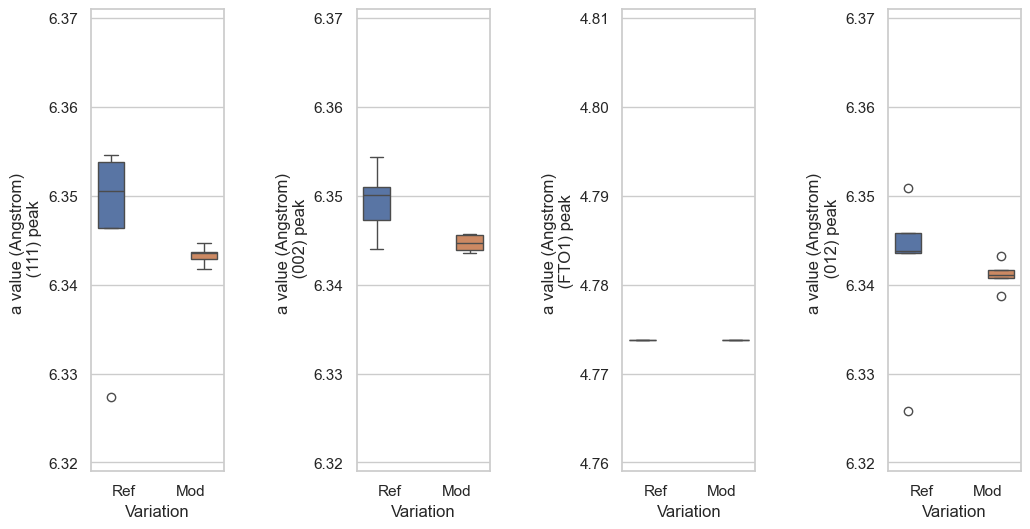

In [28]:
#A plot of the aligned a-value value

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
ax1, ax2, ax3, ax4 = axes.flatten()
i = 0

B_df = result_df[result_df['Sample'].str.startswith('H')==0]
main_df = B_df[B_df['Sample'].str.startswith('F')==0]
ini_df = main_df[main_df['Sample'].str.endswith('scan10')==0]
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(111)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(002)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'FTO(110)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(012)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax4)

'''sns.boxplot(data=result_df[result_df['Peak'] == 'p(111)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(002)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=result_df[result_df['Peak'] == 'FTO(110)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(012)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax4)'''

ax1.set_ylim(6.319,6.371)
ax2.set_ylim(6.319,6.371)
ax3.set_ylim(4.759,4.811)
ax4.set_ylim(6.319,6.371)
ax1.set_ylabel('a value (Angstrom) \n (111) peak')
ax2.set_ylabel('a value (Angstrom) \n (002) peak')
ax3.set_ylabel('a value (Angstrom) \n (FTO1) peak ')
ax4.set_ylabel('a value (Angstrom) \n (012) peak')


<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2423796052.py:9: SyntaxWarning: invalid escape sequence '\T'
  g.set_axis_labels('','2$\Theta$', fontsize=18)
c:\Users\fbaumann\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\fbaumann\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


IndexError: tuple index out of range

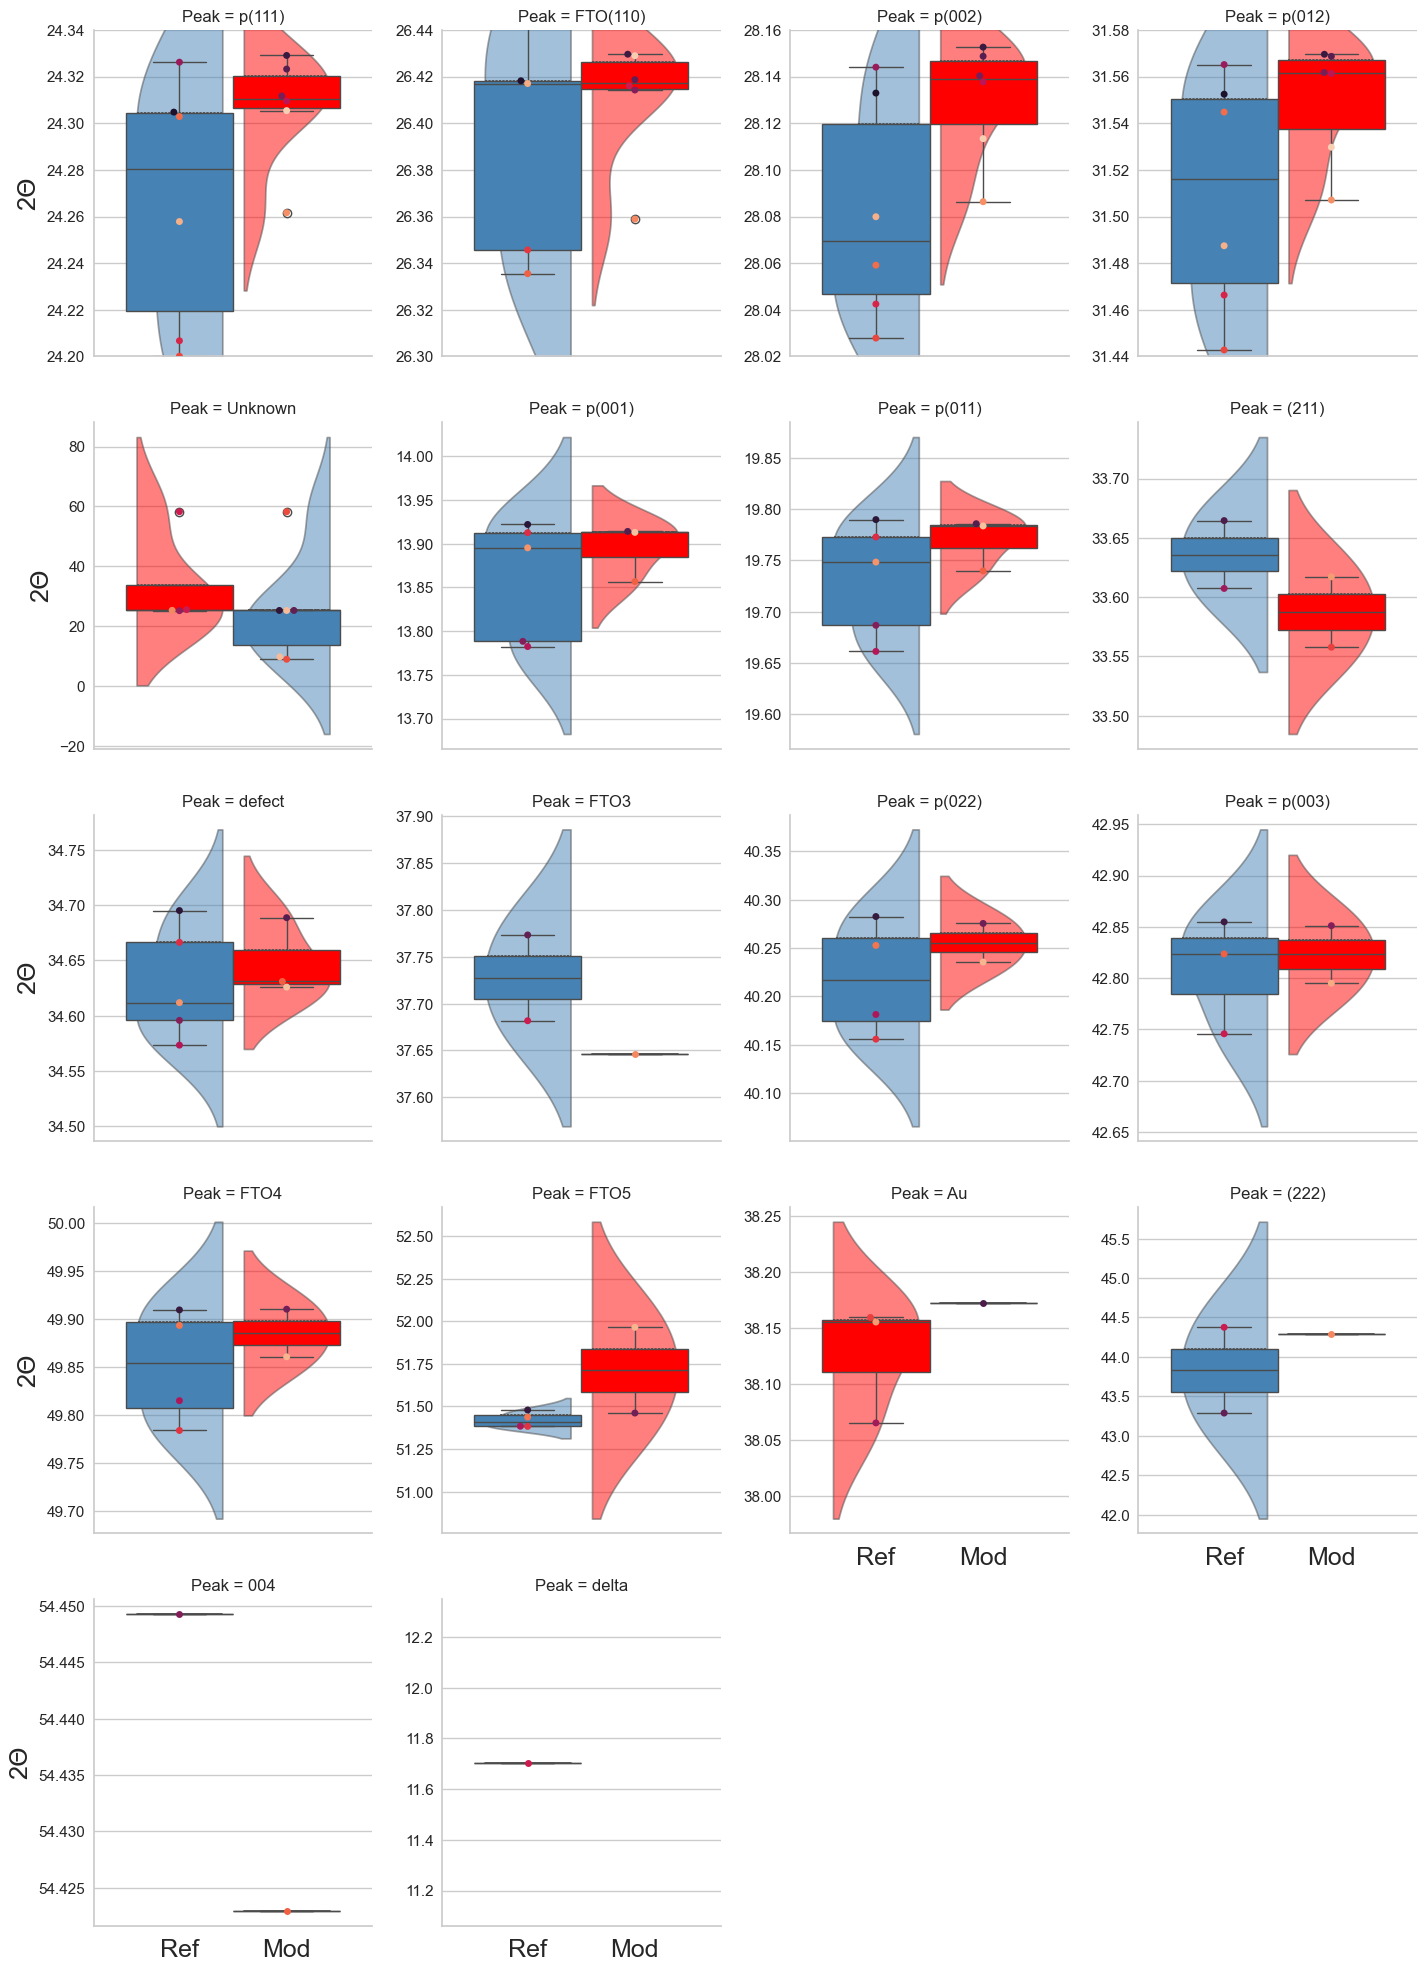

In [31]:
x_tick = result_df['Variation'].unique()
sns.set(style="whitegrid")
g = sns.FacetGrid(result_df, col="Peak", col_wrap=4, aspect=0.9, height=4, sharey=False)
# Boxplot with hue on each facet
g.map_dataframe(sns.swarmplot, x='Variation', y='pos', hue='Sample', dodge=False, palette='rocket')
violin = g.map_dataframe(sns.violinplot, x='Variation', y='pos', hue='Variation', split=True, inner='quartile', palette=['steelblue', 'red'], saturation=1,  alpha=0.5)
g.map_dataframe(sns.boxplot, x = 'Variation', y= 'pos', hue='Variation', palette=['steelblue', 'red'], saturation=1, width=1)
#legd = g.add_legend(title='Peak center ( 2$\dot{\Theta}$, Gaussian) after alignment to FTO1')
g.set_axis_labels('','2$\Theta$', fontsize=18)
g.set_xticklabels(x_tick, fontsize=18)
g.tick_params('y', size=14, pad=-8)
matplotlib.rcParams.update({'figure.autolayout': False})

tick_lims = ([24.20, 24.34],[26.30, 26.44], [28.02, 28.16], [31.44, 31.58])
for i, ax in enumerate(g.axes.flat):
    ax.set_ylim(tick_lims[i])
    ax.set_xlim([-0.8, len(result_df['Variation'].unique())-0.2])
    tick_array = np.linspace(tick_lims[i][0], tick_lims[i][1], 7)
    #ax.set_yticklabels([f'{tick:.2f}' for tick in tick_array], fontsize=16)

for ax in g.axes.flat:
    for artist in ax.collections:
        artist.set_alpha(0.5)  # Set transparency here
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

In [32]:
#Reading in the initial scans to plot the full spectra
initial = pd.DataFrame(columns=['Variation', 'X', 'Y', 'Y_BC'])
print(df_complet)
for row in df_complet.index:
    #shift = df_complet['rel_a'][row]
    x_array = [float(column) for column in df_complet.columns[7:]]
    y_array = [df_complet[column][row] for column in df_complet.columns [7:]]
    x_carray = np.array(x_array)
    y_carray = np.array(y_array)
    estimated_background = airpls(y_carray)
    y_bc_carray = y_carray-estimated_background
    if df_complet['FileName'][row].startswith('2'):
        var = df_complet['Variation'][row]
        for i,x in enumerate(x_carray): 
            new_instance = {
            'Variation': var, 
            'X': x, 
            'Y': y_carray[i],
            'Y_BC': y_bc_carray[i]
            }
            initial.loc[len(initial.index)] = new_instance  
    #amplitude, mean, cov = fit_to_peak(x_array[600:670], y_bc_carray[600:670], False)
    #centers_fto1.append(mean)
    #amplitudes.append(amplitude)
print(initial)
        

  Variation Voltage    Sample                         FileName  8.01877  \
0       Ref       0   B1105P7            1105-01_S7_0V_complet      347   
1       Mod    none  B1105P11         1105-01_S11_H3PP_complet      331   
2       Ref       0   B1205P5            1205-01_S5_0V_complet      355   
3       Ref       0   B1205P7            1205-01_S7_0V_complet      442   
4       Ref       0   B1205P7    1205-02_S7_0V_visible_complet      402   
5       Ref    none      B4P5  2006-01_Sample5_visible_complet      623   
6       Mod    none     B4P18         2106-01_Sample18_complet      582   

   8.04831  8.07786  8.1074  8.13694  8.16649  ...  59.71926  59.7488  \
0      377      307     303      336      344  ...        74       84   
1      371      331     348      366      357  ...        67       75   
2      340      374     361      356      360  ...        71       72   
3      390      430     396      407      375  ...        77       76   
4      415      365     398      3

In [33]:
#Reading in the "after" scans at scan 10 (13 hours into the experiment) to plot the full spectra
x_ref = [float(column) for column in df_after_complet.columns[4:]]
y_ref = [df_after_complet[column].iloc[0] for column in df_after_complet.columns[4:]]
y_aref = np.array(y_ref)
x_aref = np.array(x_ref)
y_bc_aref = y_ref - airpls(y_aref)
#shift_mod = df_partial['ShiftP'].iloc[1]
x_mod = [float(column) for column in df_after_complet.columns[4:]]
y_mod = [df_after_complet[column].iloc[1] for column in df_after_complet.columns[4:]]
y_amod = np.array(y_mod)
x_amod = np.array(x_mod)
y_bc_amod = y_mod - airpls(y_amod)

<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:25: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:25: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2983225834.py:4: SyntaxWarning: invalid escape sequence '\T'
  ax1.set_xlabel('2$\Theta$', size=12, labelpad=-2)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2983225834.py:25: SyntaxWarning: invalid escape sequence '\T'
  ax2.set_xlabel('2$\Theta$',size=12, labelpad=-2)


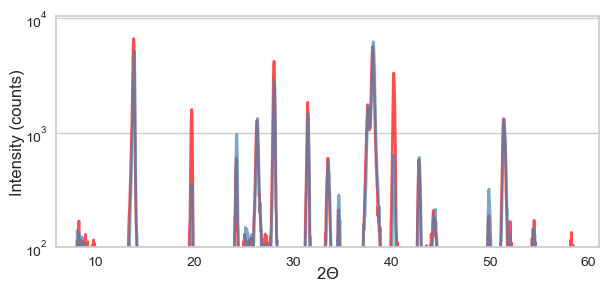

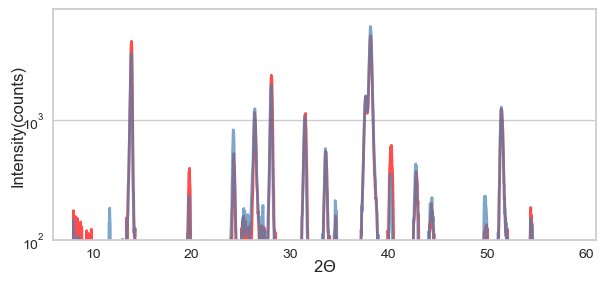

In [34]:
#Before plot and after plot
fig1 = plt.figure(figsize=(7,3))
ax1 = fig1.gca()
ax1.set_xlabel('2$\Theta$', size=12, labelpad=-2)
ax1.set_ylabel('Intensity (counts)', size=12, labelpad=0)
ax1.set_xlim(6,61)
ax1.set_ylim(100,10400)
ax1.set_yscale('log')
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax1.tick_params(axis='both', labelsize=10, pad=0)
ax1.grid(axis='y',visible=True)
ax1.grid(axis='x',visible=False)
#ax1.tick_params('both', size=6)

mod_initial = initial[initial['Variation']=='Mod']
y_mod_carray = [y for y in mod_initial['Y_BC']]
ax1.plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.7, lw=2)  #[600:670]          
ref_initial = initial[initial['Variation']=='Ref']
y_ref_carray = [y for y in ref_initial['Y_BC']]
ax1.plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.7, lw=2)  #[600:670]

     
fig2 = plt.figure(figsize=(7,3))
ax2 = fig2.gca()
ax2.set_xlabel('2$\Theta$',size=12, labelpad=-2)
ax2.set_ylabel('Intensity(counts)', size=12, labelpad=-2)
ax2.tick_params(axis='both', labelsize=10, pad=0)
ax2.plot(x_amod,y_bc_amod, color='red', alpha=0.7, lw=2)
ax2.plot(x_aref,y_bc_aref, color='steelblue', alpha=0.7, lw=2)
ax2.set_xlim(6,61)
ax2.set_ylim(100,8400)
ax2.set_yscale('log')
ax2.grid(axis='y',visible=True)
ax2.grid(axis='x',visible=False)
#shift_ref = df_partial['ShiftP'].iloc[0]


<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\4131881971.py:5: SyntaxWarning: invalid escape sequence '\T'
  ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\4131881971.py:29: SyntaxWarning: invalid escape sequence '\T'
  fig.suptitle('2$\Theta$', size=22, y=0.03)


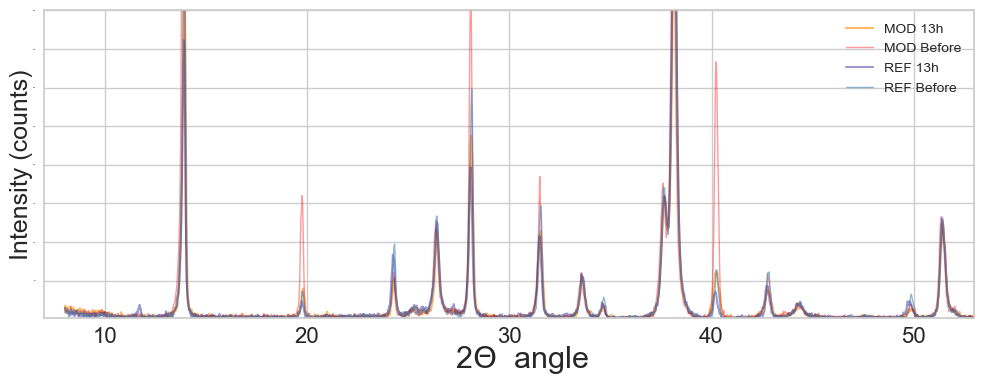

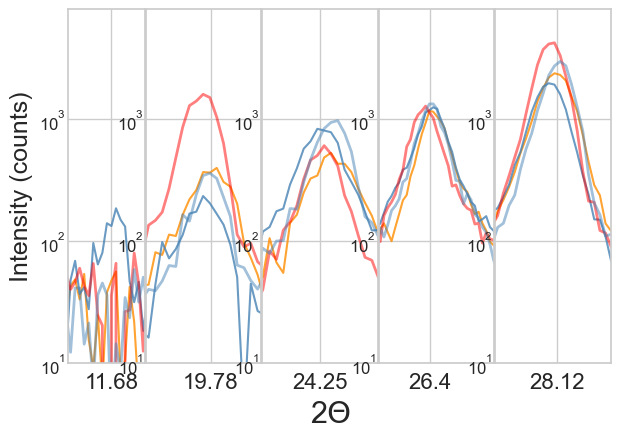

In [35]:
#Before/After for each variation

fig1 = plt.figure(figsize=(12,4))
ax1 = fig1.gca()
ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
ax1.set_ylabel('Intensity (counts)', size=18, labelpad=0)
ax1.set_xlim(7,53)
ax1.set_ylim(10,4000)
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax1.tick_params(axis='x', labelsize=16, pad=0)
ax1.tick_params(axis='y', labelsize=0, pad=0)
ax1.set_xticks([10,20,30,40,50])
ax1.grid(axis='y',visible=True)

ax1.plot(x_amod,y_bc_amod, color='darkorange', alpha=0.6, lw=1.5, label='MOD 13h')
mod_initial = initial[initial['Variation']=='Mod']
y_mod_carray = [y for y in mod_initial['Y_BC']]
ax1.plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.4, lw=1, label='MOD Before')  #[600:670]

ax1.plot(x_ref,y_bc_aref, color='navy', alpha=0.4, lw=1.5, label='REF 13h')
ref_initial = initial[initial['Variation']=='Ref']
y_ref_carray = [y for y in ref_initial['Y_BC']]
ax1.plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.6, lw=1, label='REF Before')  #[600:670]
ax1.legend(loc='upper right', frameon=False, fontsize=10)



fig, axs = plt.subplots(1, 5, figsize=(7, 4.6), gridspec_kw={'width_ratios': [2, 3,3,3,3]})
fig.suptitle('2$\Theta$', size=22, y=0.03)

axs[3].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[3].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[3].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[3].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[3].set_xlim(26.0,26.9)
axs[3].set_xticks([26.4])

axs[4].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[4].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[4].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[4].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[4].set_xlim(27.8,28.4)
axs[4].set_xticks([28.12])


axs[1].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[1].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[1].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[1].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[1].set_xlim(19.5, 20.0)  # Set the x-axis limits for the first interval
axs[1].set_xticks([19.78])

axs[2].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[2].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[2].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[2].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
#axs[2].set_xlim(39.5,41.5)
#axs[2].set_xticks([40.3])
axs[2].set_xlim(24.0,24.5)
axs[2].set_xticks([24.25])



axs[0].set_ylabel('Intensity (counts)', size=18)
axs[0].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[0].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[0].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[0].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[0].set_xlim(11.4,11.9)
axs[0].set_xticks([11.68])


for ax in axs:
    ax.grid(axis='both', visible=True)
    ax.tick_params(axis='y', length=2, labelsize=12, pad=0)
    ax.tick_params(axis='x', pad=0, labelsize=16)
    ax.set_yticks([0, 1500, 3000, 4500, 6000, 7500])
    ax.set_yscale('log')
    ax.set_ylim(10,8000)

# Add a gap in the x-axis between the two subplots
plt.subplots_adjust(wspace=0.01)

# Show the plot
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:33: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:33: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2684378111.py:5: SyntaxWarning: invalid escape sequence '\T'
  ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2684378111.py:33: SyntaxWarning: invalid escape sequence '\T'
  fig.suptitle('2$\Theta$', size=22, y=0.03)


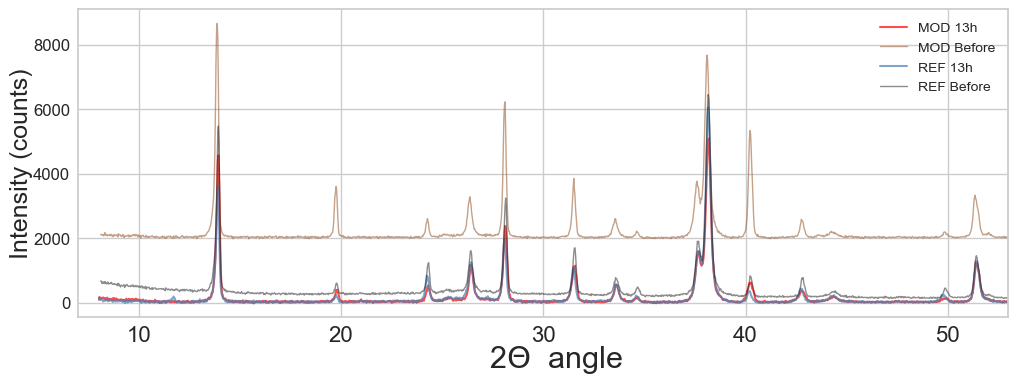

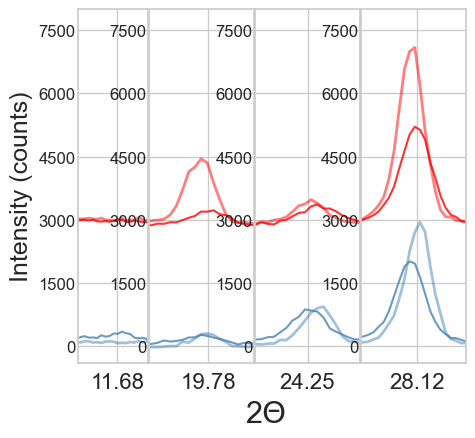

In [38]:
#Before/After for each variation

fig1 = plt.figure(figsize=(12,4))
ax1 = fig1.gca()
ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
ax1.set_ylabel('Intensity (counts)', size=18, labelpad=0)
ax1.set_xlim(7,53)
#ax1.set_ylim(-1000,14400)
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax1.tick_params(axis='x', labelsize=16, pad=0)
ax1.tick_params(axis='y', labelsize=12, pad=0)
ax1.set_xticks([10,20,30,40,50])
ax1.grid(axis='y',visible=True)

ax1.plot(x_amod,y_bc_amod, color='red', alpha=0.7, lw=1.5, label='MOD 13h')
mod_initial = initial[initial['Variation']=='Mod']
y_mod_carray = [y+2000 for y in mod_initial['Y_BC']]
ax1.plot(mod_initial['X'], y_mod_carray, color = 'saddlebrown', alpha= 0.5, lw=1, label='MOD Before')  #[600:670]

x_ref = [float(column) for column in df_after_complet.columns[4:]]
#y_ref = [df_after_complet[column].iloc[0]+1800 for column in df_after_complet.columns[4:]]
ax1.plot(x_aref,y_bc_aref, color='steelblue', alpha=0.7, lw=1.5, label='REF 13h')
ref_initial = initial[initial['Variation']=='Ref']
y_ref_carray = [y for y in ref_initial['Y']]
ax1.plot(ref_initial['X'], y_ref_carray, color = 'k', alpha= 0.5, lw=1, label='REF Before')  #[600:670]
ax1.legend(loc='upper right', frameon=False, fontsize=10)



fig, axs = plt.subplots(1, 4, figsize=(5, 4.6), gridspec_kw={'width_ratios': [2, 3,3,3]})


fig.suptitle('2$\Theta$', size=22, y=0.03)
#ax3.set_ylabel('Intensity (counts)', size=12)

'''#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax3.tick_params(axis='both', labelsize=10, pad=-2)
ax3.set_xticks([27.92, 28.12, 28.32])
ax3.set_yticks([0, 1500, 3000, 4500, 6000])
ax3.grid(axis='y',visible=True)'''
y_modin_002 = [y+2600 for y in mod_initial['Y']]
y_mod_002 = [df_after_complet[column].iloc[1]+2600 for column in df_after_complet.columns[4:]]
y_ref_002 = [df_after_complet[column].iloc[0]-200 for column in df_after_complet.columns[4:]]
#ax3.plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)  #[600:670]   
y_refin_002 = [y-300 for y in ref_initial['Y']]
#ax3.plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2)  #[600:670]



axs[3].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[3].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[3].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[3].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
axs[3].set_xlim(27.8,28.4)
axs[3].set_ylim(-400,8000)
axs[3].set_xticks([28.12])


axs[1].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[1].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[1].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[1].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
axs[1].set_xlim(19.5, 20.0)  # Set the x-axis limits for the first interval
axs[1].set_xticks([19.78])
axs[1].set_ylim(-400,8000)

axs[2].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[2].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[2].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[2].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
#axs[2].set_xlim(39.5,41.5)
#axs[2].set_xticks([40.3])
axs[2].set_xlim(24.0,24.5)
axs[2].set_xticks([24.25])
axs[2].set_ylim(-400,8000)


axs[0].set_ylabel('Intensity (counts)', size=18)
axs[0].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[0].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[0].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[0].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
axs[0].set_xlim(11.4,11.9)
axs[0].set_xticks([11.68])
axs[0].set_ylim(-400,8000)

for ax in axs:
    ax.grid(axis='both', visible=True)
    ax.tick_params(axis='y', length=2, labelsize=12, pad=0)
    ax.tick_params(axis='x', pad=0, labelsize=16)
    ax.set_yticks([0, 1500, 3000, 4500, 6000, 7500])

# Add a gap in the x-axis between the two subplots
plt.subplots_adjust(wspace=0.01)

# Show the plot
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_13760\319597765.py:2: SyntaxWarning: invalid escape sequence '\T'
  axs[1].set_xlabel('2$\Theta$', size=12)


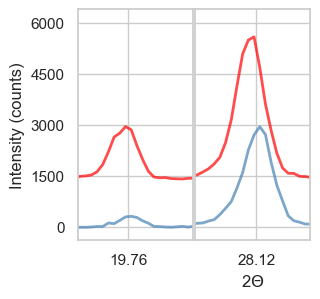

In [121]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3, 3))
axs[1].set_xlabel('2$\Theta$', size=12)
#ax3.set_ylabel('Intensity (counts)', size=12)

'''#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax3.tick_params(axis='both', labelsize=10, pad=-2)
ax3.set_xticks([27.92, 28.12, 28.32])
ax3.set_yticks([0, 1500, 3000, 4500, 6000])
ax3.grid(axis='y',visible=True)'''
y_mod_002 = [y+1100 for y in mod_initial['Y']]
#ax3.plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)  #[600:670]   
y_ref_002 = [y-300 for y in ref_initial['Y']]
#ax3.plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2)  #[600:670]

axs[1].plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)
axs[1].plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2) 
axs[1].set_xlim(27.8,28.4)
axs[1].set_ylim(-400,6400)
axs[1].set_xticks([28.12])

axs[0].set_yticks([0, 1500, 3000, 4500, 6000])
axs[0].set_ylabel('Intensity (counts)', size=12)
axs[0].plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)
axs[0].plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2) 
axs[0].set_xlim(19.5, 20.1)  # Set the x-axis limits for the first interval
axs[0].set_xticks([19.76])

# Add a gap in the x-axis between the two subplots
plt.subplots_adjust(wspace=0.01)

# Show the plot
plt.show()